# Zillow Home Value Time Series Forecast

## Table of Contents

## Motivation and Objective

# Load Data and Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import itertools

# modeling/metric libraries
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import statsmodels.graphics.tsaplots as tsa
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# visualization libraries
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 8
import seaborn as sns
sns.set()
import plotly.express as px
import datetime

# functions I've written 
import functions as fun

In [2]:
%load_ext autoreload
%autoreload

In [3]:
# plotting dfs:
('csv/roi_df_plotting.csv')
('csv/top_percent_roi_plotting.csv')
('csv/chi_plot.csv')

# modeling dfs:
('csv/top_roi_for_melting.csv')



'csv/top_roi_for_melting.csv'

In [4]:
df = pd.read_csv('csv/chicago_melted.csv')
df.head()

,ZipCode,Time,Value
0,60657,2011-01-01,729300.0
1,60614,2011-01-01,923000.0
2,60640,2011-01-01,600000.0
3,60647,2011-01-01,286500.0
4,60618,2011-01-01,317400.0


# EDA / Preprocessing / Visualizations

In [5]:
df.columns

Index(['ZipCode', 'Time', 'Value'], dtype='object')

In [6]:
# set time as the index and a pandas time series
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m')
df.set_index('Time', inplace = True)
df.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [7]:
df.index

DatetimeIndex(['2011-01-01', '2011-01-01', '2011-01-01', '2011-01-01',
               '2011-01-01', '2011-01-01', '2011-01-01', '2011-01-01',
               '2011-01-01', '2011-01-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Time', length=1760, freq=None)

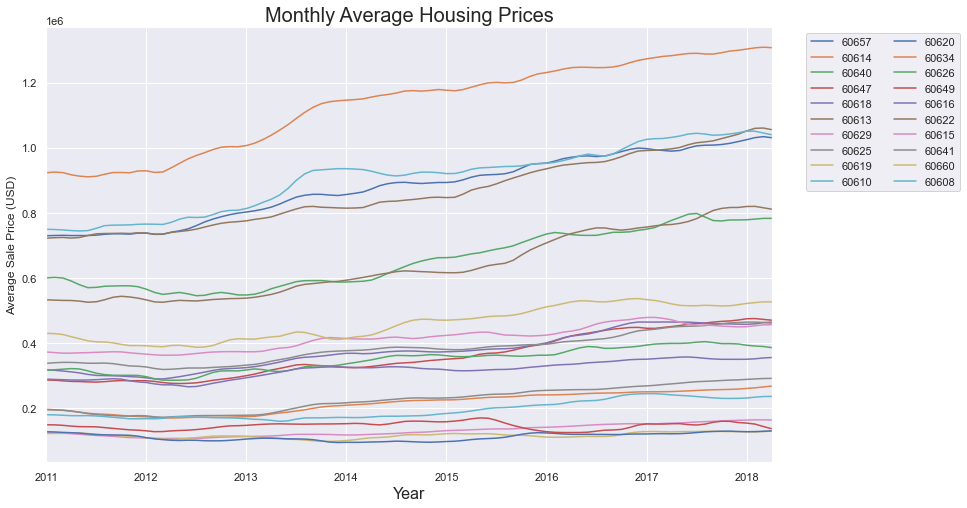

In [8]:
 # iterates through all unique zip codes to plot corresponding value with time stamp
for zipcode in df.ZipCode.unique(): 
    df[df.ZipCode == zipcode]['Value'].plot(figsize = (13,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices', fontsize = 20);

In [9]:
df.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [10]:
# make a dictionary that holds each zip code along with it's home values for all dates
zip_dict = {}
zip_list = df.ZipCode.unique() # creates list of the unique zip codes
for code in zip_list:  # iterates through zip code list and attachs all values to that zip code 
    ts = (df[df['ZipCode']==code]['Value'].copy())
    ts.name = code 
    zip_dict[code] = ts 

In [11]:
zip_dict[60647]

Time
2011-01-01    286500.0
2011-02-01    285800.0
2011-03-01    283800.0
2011-04-01    282100.0
2011-05-01    281700.0
                ...   
2017-12-01    470600.0
2018-01-01    474500.0
2018-02-01    475100.0
2018-03-01    472600.0
2018-04-01    470200.0
Name: 60647, Length: 88, dtype: float64

In [12]:
# df_dict = pd.DataFrame(pd.concat(zip_dict))
zip_list

array([60657, 60614, 60640, 60647, 60618, 60613, 60629, 60625, 60619,
       60610, 60620, 60634, 60626, 60649, 60616, 60622, 60615, 60641,
       60660, 60608])

In [13]:
for name in zip_list:
    train_2 = zip_dict[name].loc['2011-01-01':'2015-03-01']
    test_2 = zip_dict[name].loc['2015-04-01':]

In [14]:
# train_2
# test_2

In [15]:
month_avg = df.groupby('Time')['Value'].mean()
month_avg.head()

Time
2011-01-01    385045.0
2011-02-01    384930.0
2011-03-01    383990.0
2011-04-01    381915.0
2011-05-01    379965.0
Name: Value, dtype: float64

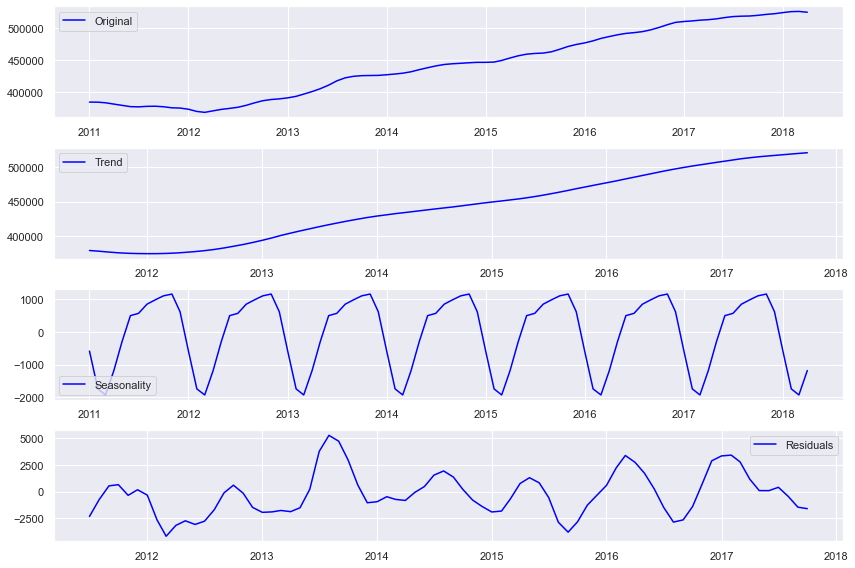

In [16]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model='additive')
# choosing additive because our housing values have a linear and constant upward trend with no gaps in time

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

This shows an upward trend is present with yearly seasonality.
We can check the stationarity of the residuals with the Dickey Fuller Test.

The null hypothesis states that the data is not stationary, and the alternative hypothesis is that the data is stationarity.

In [17]:
df.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [18]:
def stationarity_check(TS):
    
    # Import adfuller
#     from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

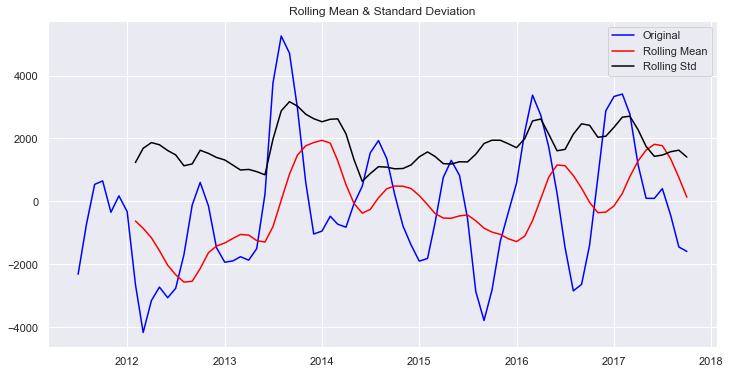

Results of Dickey-Fuller Test: 

Test Statistic                 -4.904374
p-value                         0.000034
#Lags Used                      3.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [19]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
stationarity_check(ts_log_decompose)

The p-value is less than 0.05 which means we reject the hypothesis and that the monthly average for all highly urbanized Chicago zip codes is stationary.

Let's check all zip codes to be safe!

In [20]:
df.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


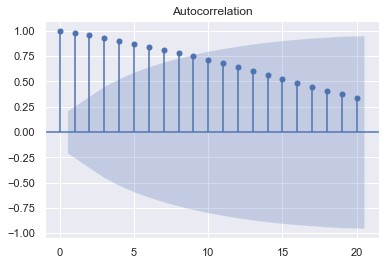

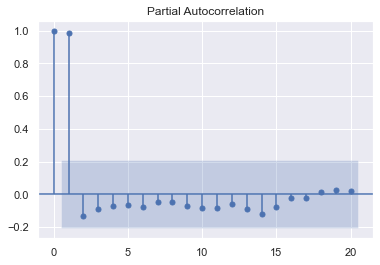

In [21]:
tsa.plot_acf(month_avg);
tsa.plot_pacf(month_avg);

The monthly average house price of Chicago increased year over year. 
No obvious autocorrelation and partial autocorrelation is present.

<AxesSubplot:xlabel='Time'>

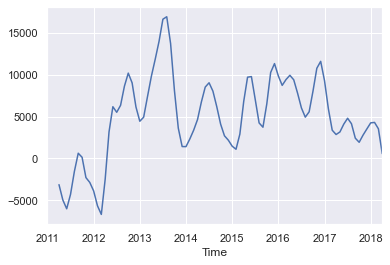

In [22]:
month_avg.diff(periods=3).plot()

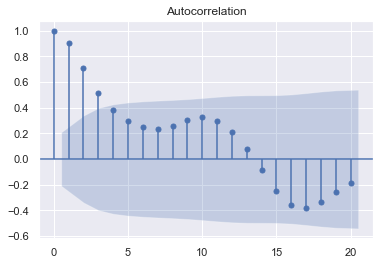

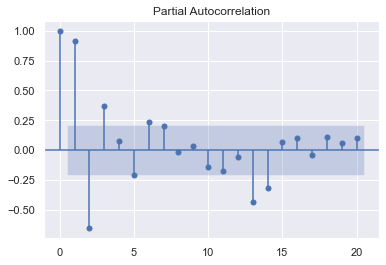

In [23]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from matplotlib.pylab import rcParams

# rcParams['figure.figsize']=7,5
tsa.plot_acf(month_avg.diff(periods=3).bfill()); 
tsa.plot_pacf(month_avg.diff(periods=3).bfill()); 

In [24]:
df.head()


,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [ ]:
temp = df.copy()

In [27]:
temp.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [28]:
zip_dfs = []
zip_list = df.ZipCode.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(temp[temp['ZipCode']==x][['Value']].copy()))

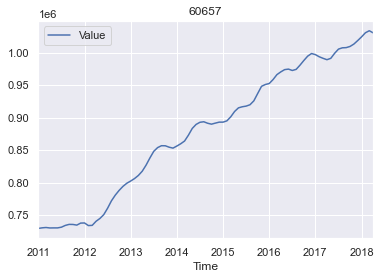

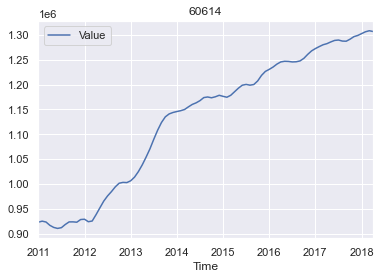

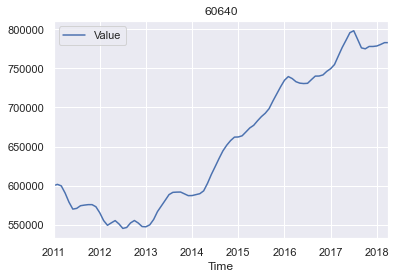

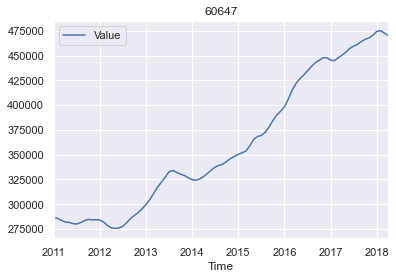

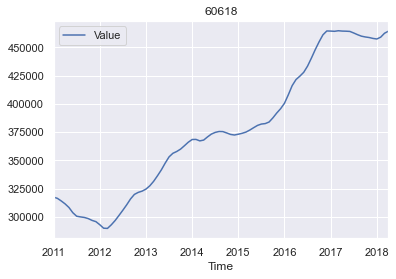

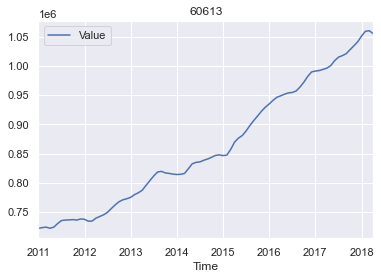

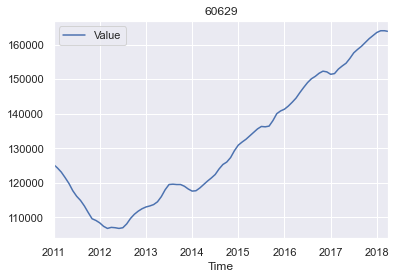

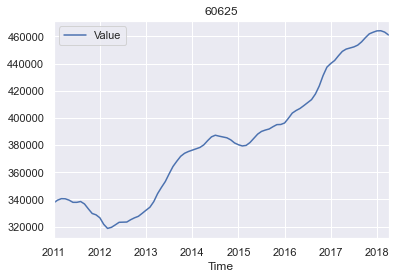

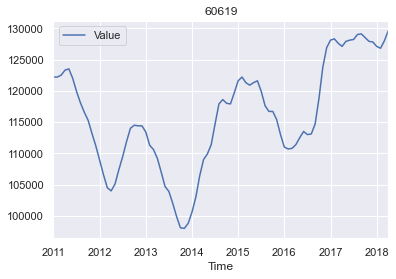

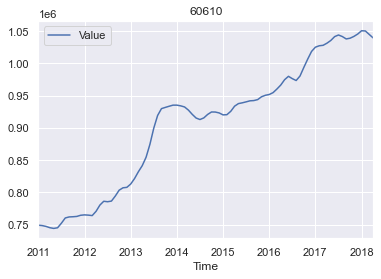

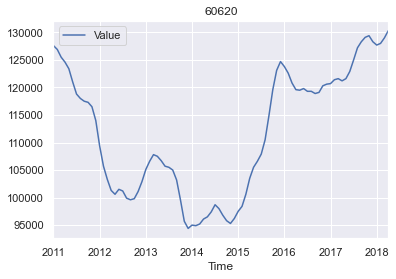

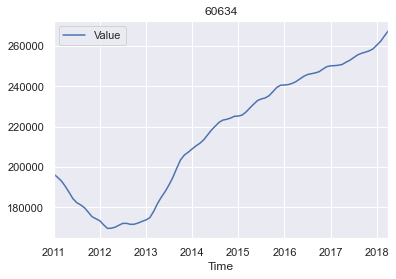

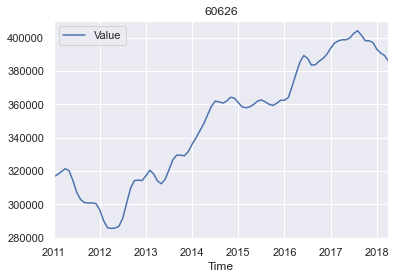

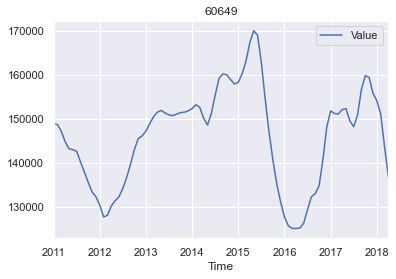

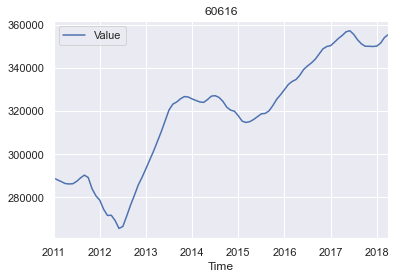

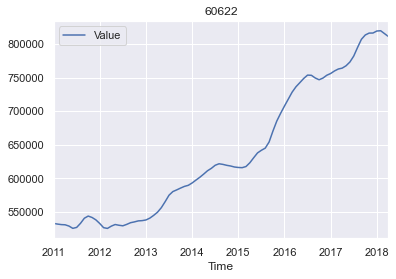

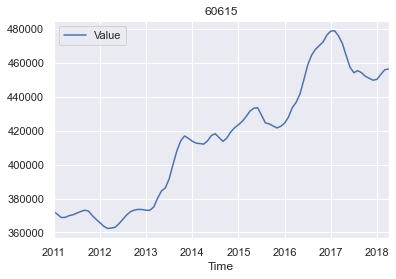

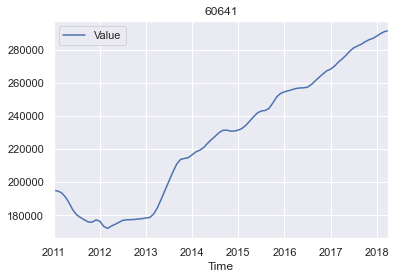

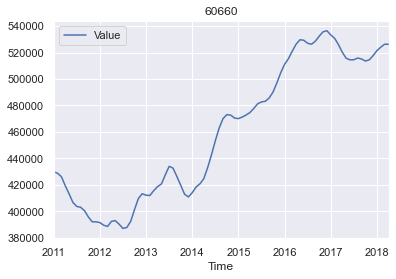

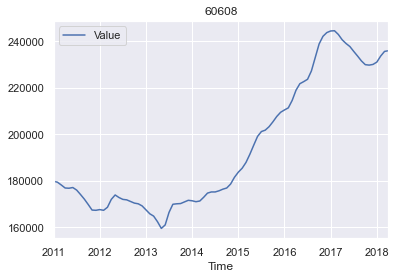

In [29]:
# plotting each unique zip code's 
for dfs, name in zip(zip_dfs, zip_list):
    dfs.plot()
    plt.title(name)
    plt.show()

In [31]:
df_all_zips = pd.DataFrame(zip_dict)
df_all_zips.head()

,60657,60614,60640,60647,60618,60613,60629,60625,60619,60610,60620,60634,60626,60649,60616,60622,60615,60641,60660,60608
Time,,,,,,,,,,,,,,,,,,,,
2011-01-01,729300.0,923000.0,600000.0,286500.0,317400.0,722000.0,125300.0,337500.0,122200.0,749200.0,127600.0,196600.0,316500.0,148800.0,289000.0,532700.0,372500.0,195100.0,429900.0,179800.0
2011-02-01,730200.0,925000.0,601600.0,285800.0,316300.0,723400.0,124300.0,339500.0,122200.0,748600.0,126900.0,195000.0,317900.0,148700.0,288100.0,531700.0,370600.0,194600.0,428800.0,179400.0
2011-03-01,730700.0,923300.0,599700.0,283800.0,314000.0,724200.0,123100.0,340600.0,122500.0,747300.0,125500.0,193200.0,319600.0,147200.0,287300.0,530900.0,368800.0,193700.0,426200.0,178200.0
2011-04-01,730000.0,916600.0,590500.0,282100.0,311400.0,722300.0,121500.0,340500.0,123300.0,745300.0,124600.0,190600.0,321400.0,144800.0,286400.0,530600.0,368900.0,191200.0,419400.0,176900.0
2011-05-01,730100.0,912400.0,578900.0,281700.0,308200.0,724100.0,119800.0,339500.0,123500.0,744200.0,123400.0,187600.0,320300.0,143200.0,286200.0,528700.0,369900.0,187600.0,413200.0,176800.0


In [32]:
df.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [33]:
temp.head()

,ZipCode,Value
Time,,
2011-01-01,60657,729300.0
2011-01-01,60614,923000.0
2011-01-01,60640,600000.0
2011-01-01,60647,286500.0
2011-01-01,60618,317400.0


In [37]:
train_dict = {}
for name in zip_list:
    temp_train = zip_dict[name].loc['2011-01-01':'2015-03-01']
    train_dict[name] = temp_train

In [38]:
test_dict = {}
for name in zip_list:
    temp_test = zip_dict[name].loc['2015-03-01':]
    test_dict[name] = temp_test

In [39]:
train = df.loc['2011-01-01':'2015-03-01']
test =  df.loc['2015-04-01':]

In [40]:
# assigning values between 0 and 2 to the parameters p,d,q 
p = d = q = range(0,2)
# combinations of pdq
pdq = list(itertools.product(p,d,q)) 
# combinations of seasonal pdqs
pdqs = [(x[0], x[1], x[2], 12) 
        for x in list(itertools.product(p, d, q))] 

In [41]:

# # def parameter_test(dictionary, array): 
# """ This function takes in a dictionary of zip codes and an array
#         of zip codes.  It iterates through all zip codes in the zip code array, 
#         splits each zip code from the zip code dictionary into a train / test split
#         and then tests possible parameters for each zip code.
#         It then puts each zip code along with it's name, order parameter, 
#         seasonal order parameter and AIC score for every iteration into a 
#         list.  The list then becomes a dataframe and creates a dictionary
#         with all iteration parameters for each zip code.
#  """
param_dict = {}   

for name in zip_list:
    import warnings
    warnings.filterwarnings('ignore')
    ans = []
#     train = df.loc['2011-01-01':'2015-03-01']
 
#     test = df.loc['2015-04-01':]

    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.SARIMAX(train_dict[name],
                                order = para1,
                                seasonal_order = para2,
                                enforce_stationarity = False,
                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
#                     print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue
    param_dict[name] = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])
#     return param_dict, train, test

In [42]:
param_dict

{60657:      name        pdq           pdqs           AIC
 0   60657  (0, 0, 0)  (0, 0, 0, 12)  1.504638e+03
 1   60657  (0, 0, 0)  (0, 0, 1, 12)  6.452090e+06
 2   60657  (0, 0, 0)  (0, 1, 0, 12)  9.404474e+02
 3   60657  (0, 0, 0)  (0, 1, 1, 12)  1.085844e+03
 4   60657  (0, 0, 0)  (1, 0, 0, 12)  8.985884e+02
 ..    ...        ...            ...           ...
 59  60657  (1, 1, 1)  (0, 1, 1, 12)  7.282107e+02
 60  60657  (1, 1, 1)  (1, 0, 0, 12)  6.818134e+02
 61  60657  (1, 1, 1)  (1, 0, 1, 12)  6.833710e+02
 62  60657  (1, 1, 1)  (1, 1, 0, 12)  4.763149e+02
 63  60657  (1, 1, 1)  (1, 1, 1, 12)  8.342932e+02
 
 [64 rows x 4 columns],
 60614:      name        pdq           pdqs           AIC
 0   60614  (0, 0, 0)  (0, 0, 0, 12)  1.530147e+03
 1   60614  (0, 0, 0)  (0, 0, 1, 12)  1.011449e+07
 2   60614  (0, 0, 0)  (0, 1, 0, 12)  9.776342e+02
 3   60614  (0, 0, 0)  (0, 1, 1, 12)  1.023273e+03
 4   60614  (0, 0, 0)  (1, 0, 0, 12)  9.462222e+02
 ..    ...        ...            ...      

In [108]:

# models = {}
# for name in zip_list:
#     temp_orders = param_dict[name]
#     best_para = temp_orders.loc[temp_orders['AIC'].idxmin()]
# #     df = train_dict[name]

#     ARIMA_MODEL = sm.tsa.SARIMAX(train_dict[name],
#                                  order = best_para['pdq'],
#                                  seasonal_order = best_para['pdqs'],
#                                  enforce_stationarity = False,
#                                  enforce_invertibility = False,
#                                  )
    
#     output = ARIMA_MODEL.fit()
#     print('SARIMA Model Result for {}'.format(name))
#     print(output.summary().tables[1])
#     output.plot_diagnostics(figsize=(15, 18))
#     plt.show()
#     models[name] = output
#     output = models[name]                       
                           


SARIMA Model Result for 60657
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7352      0.162      4.536      0.000       0.417       1.053
ar.S.L12      -0.4169      0.227     -1.837      0.066      -0.862       0.028
sigma2      7.992e+06   3.16e+06      2.525      0.012    1.79e+06    1.42e+07


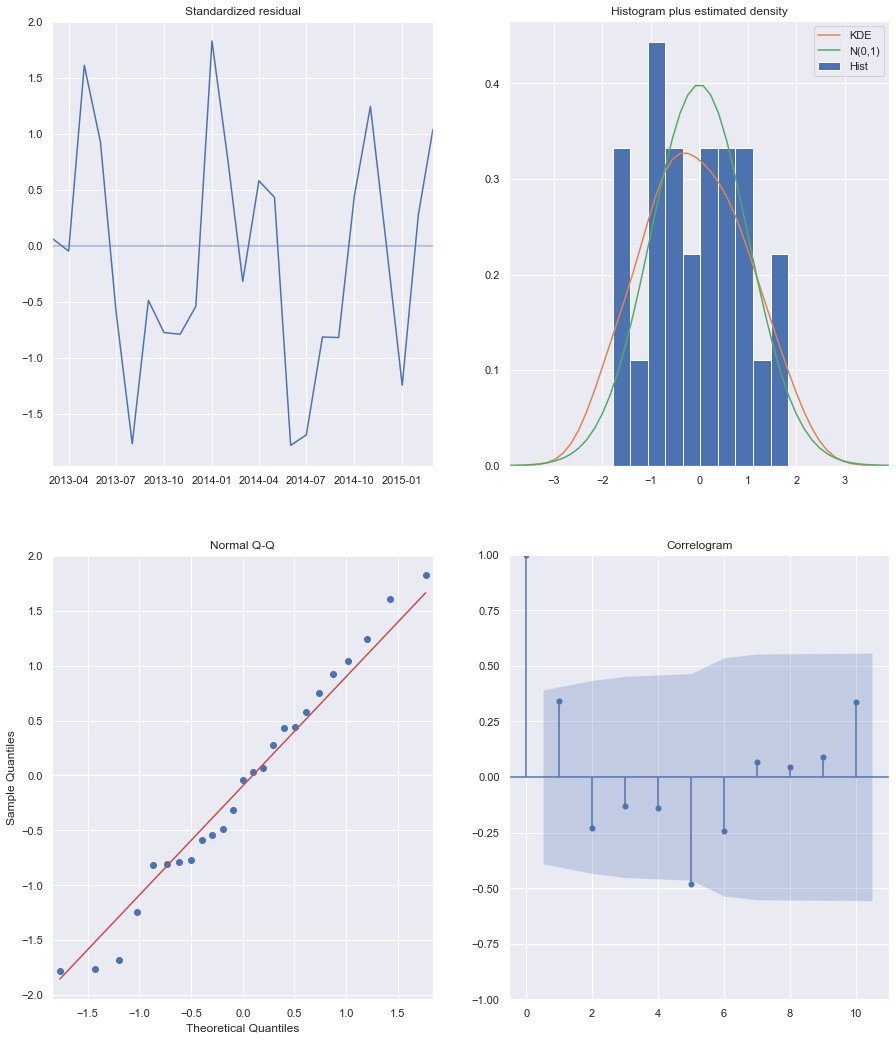

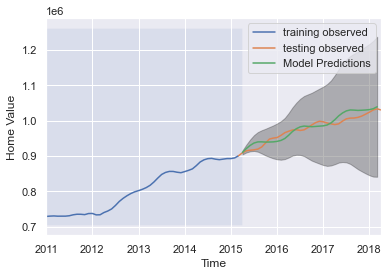

SARIMA Model Result for 60614
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8417      0.218      3.856      0.000       0.414       1.269
ma.L1          0.6385      0.233      2.735      0.006       0.181       1.096
ar.S.L12      -0.1019      0.183     -0.556      0.578      -0.461       0.257
ma.S.L12       0.1002      0.267      0.375      0.708      -0.423       0.624
sigma2      1.433e+07   2.82e-09   5.08e+15      0.000    1.43e+07    1.43e+07


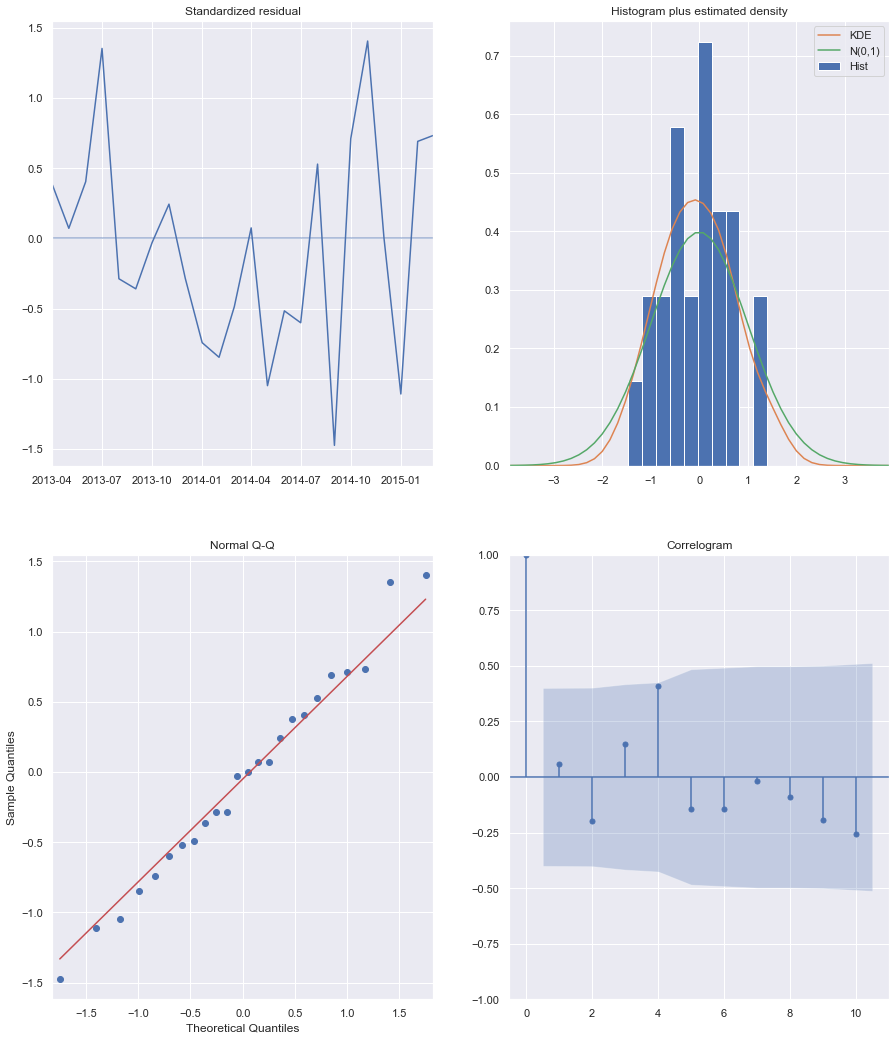

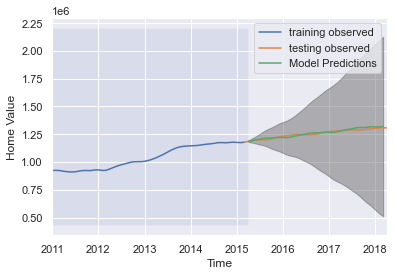

SARIMA Model Result for 60640
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4596      0.352      1.306      0.191      -0.230       1.149
ma.L1          1.1036      0.191      5.778      0.000       0.729       1.478
ar.S.L12       0.1441      0.172      0.836      0.403      -0.194       0.482
ma.S.L12      -0.0080      0.041     -0.196      0.845      -0.088       0.072
sigma2      1.041e+07    1.1e-08   9.46e+14      0.000    1.04e+07    1.04e+07


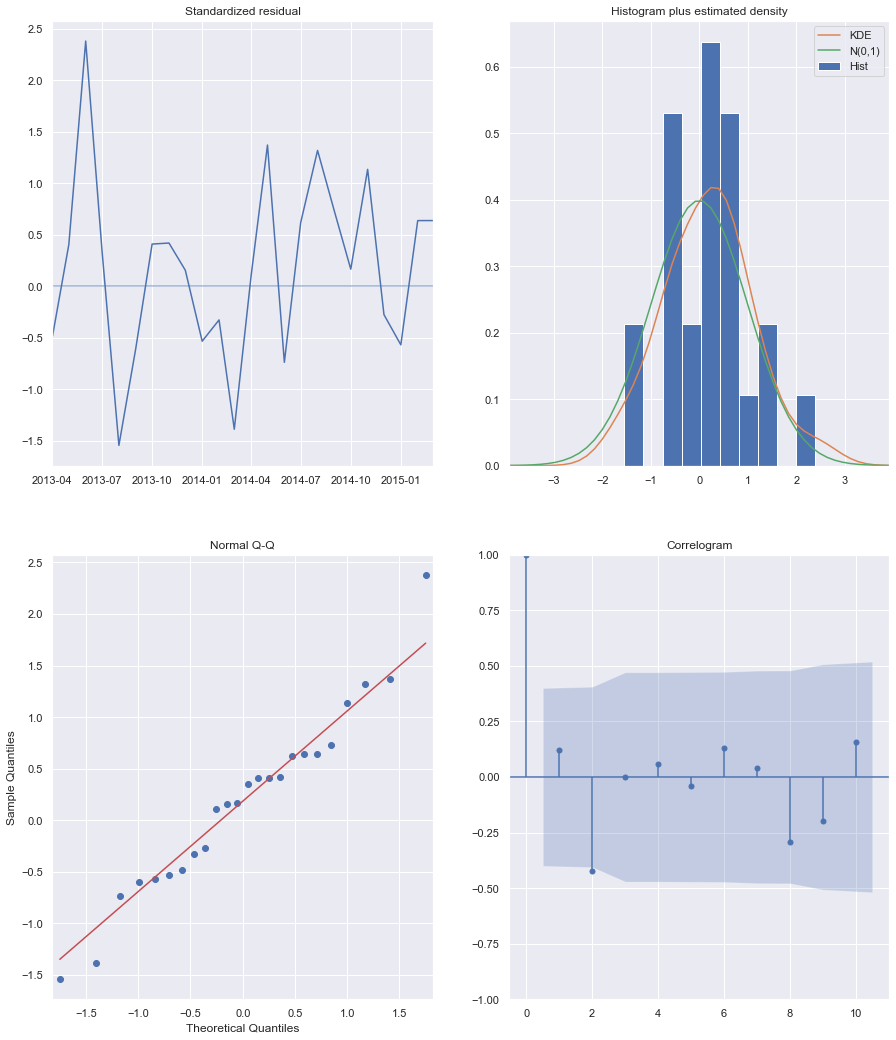

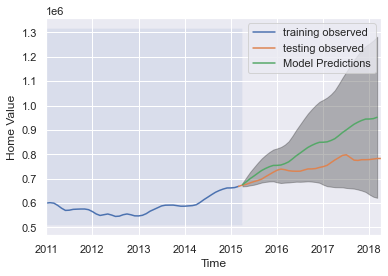

SARIMA Model Result for 60647
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7647      0.241      3.169      0.002       0.292       1.238
ma.L1          0.9645      0.470      2.052      0.040       0.043       1.886
ar.S.L12       0.0658      0.118      0.557      0.577      -0.166       0.297
ma.S.L12       0.0062      0.097      0.064      0.949      -0.185       0.197
sigma2      2.645e+06   1.57e-07   1.69e+13      0.000    2.65e+06    2.65e+06


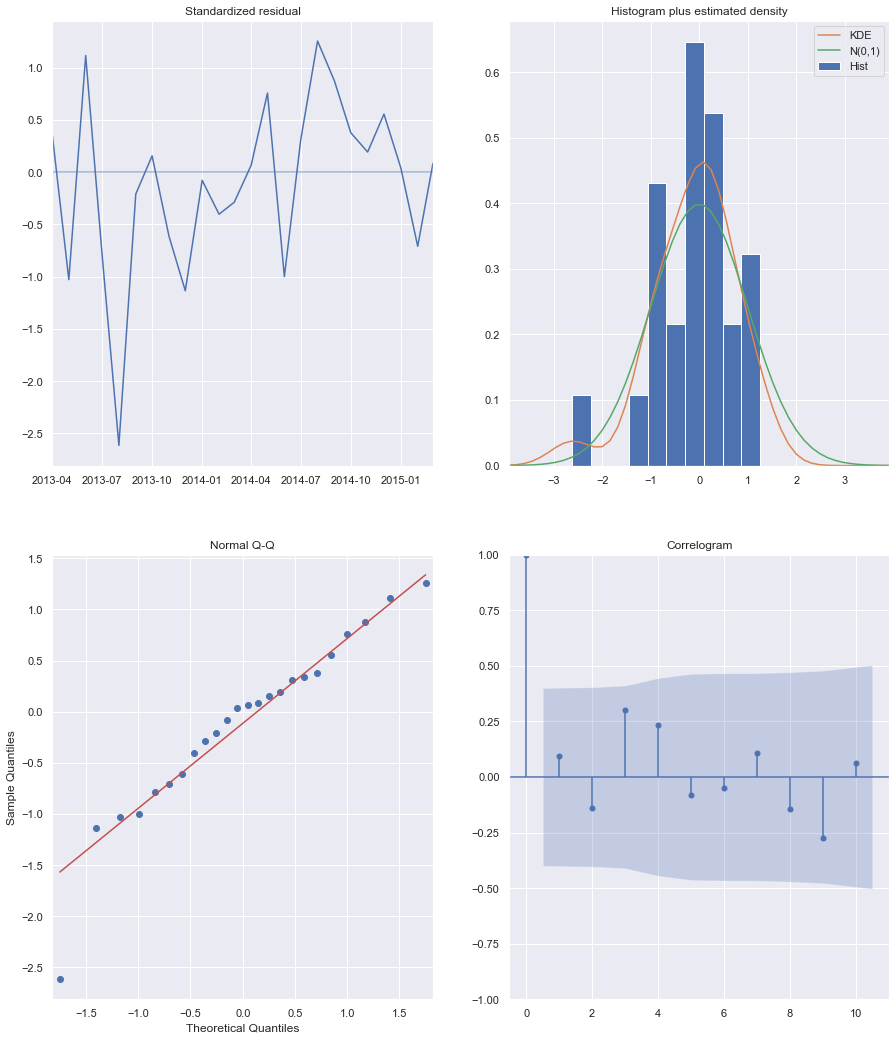

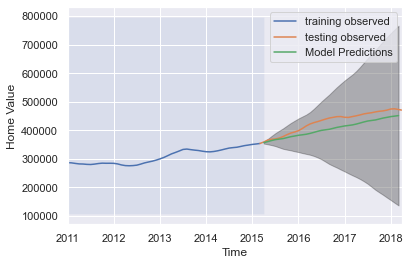

SARIMA Model Result for 60618
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8262      0.150      5.510      0.000       0.532       1.120
ma.L1          0.1907      0.123      1.547      0.122      -0.051       0.432
ar.S.L12      -0.2739      0.210     -1.304      0.192      -0.686       0.138
ma.S.L12      -0.0289      0.031     -0.923      0.356      -0.090       0.032
sigma2      1.659e+06   5.43e-08   3.05e+13      0.000    1.66e+06    1.66e+06


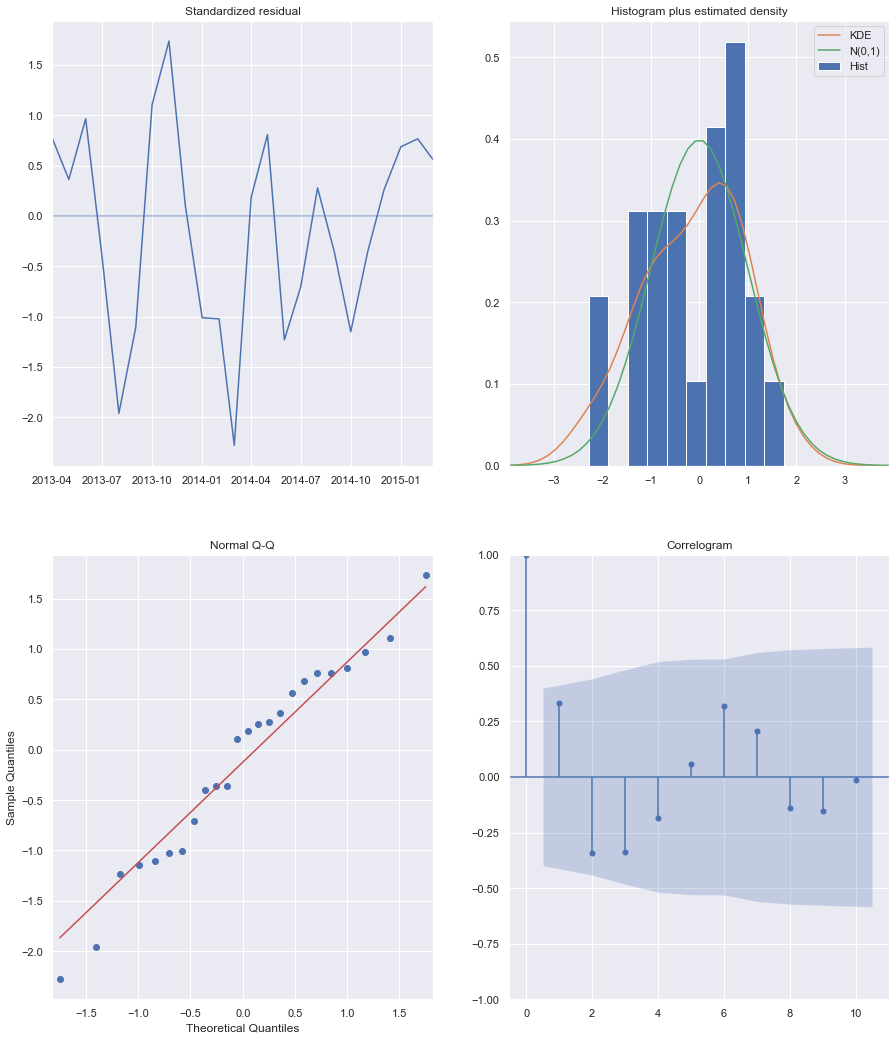

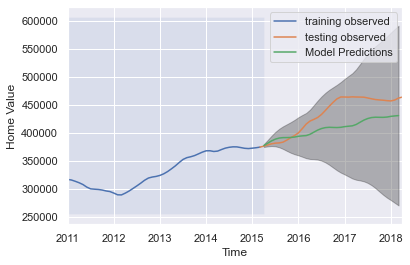

SARIMA Model Result for 60613
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5612      0.255      2.201      0.028       0.061       1.061
ar.S.L12      -0.5767      0.247     -2.338      0.019      -1.060      -0.093
sigma2      7.789e+06   1.89e+06      4.119      0.000    4.08e+06    1.15e+07


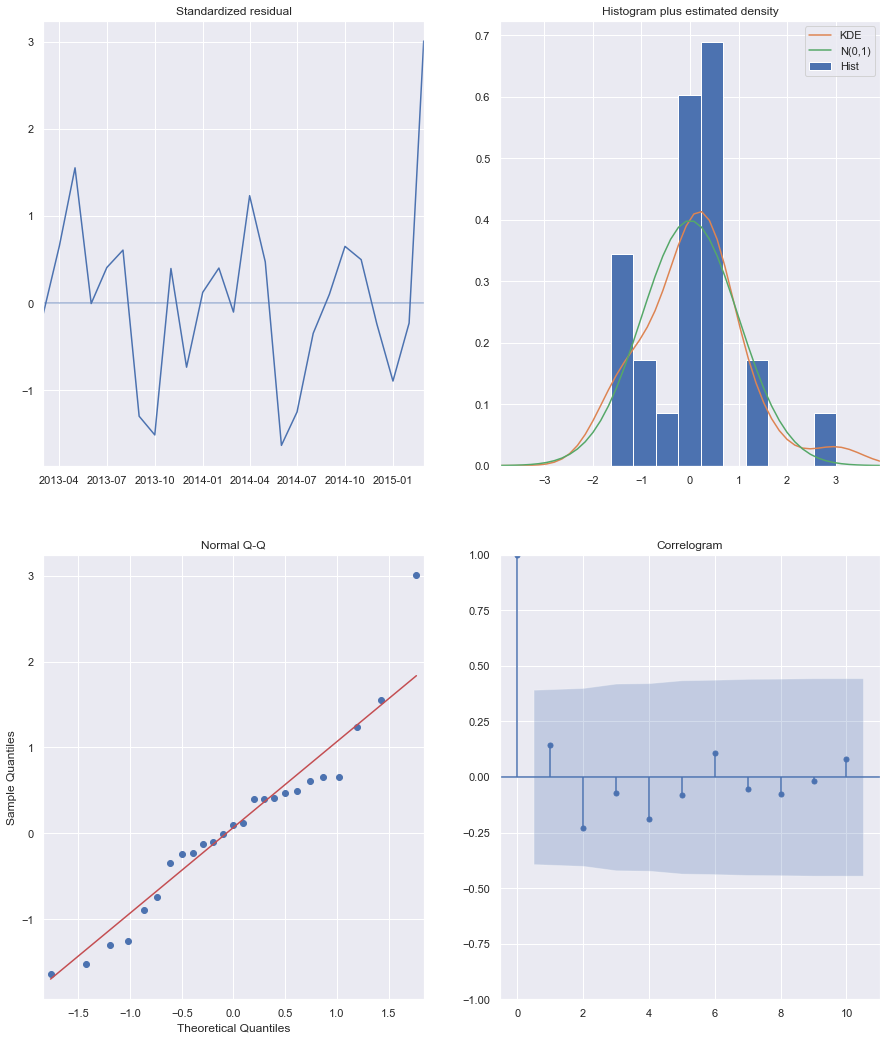

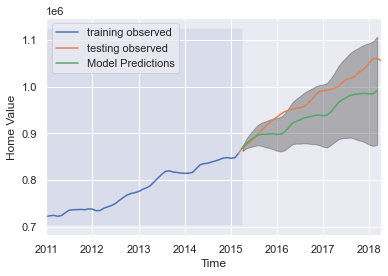

SARIMA Model Result for 60629
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5888      0.236      2.494      0.013       0.126       1.052
ma.L1          0.8821      0.233      3.792      0.000       0.426       1.338
ar.S.L12       0.0134      0.091      0.148      0.882      -0.164       0.191
sigma2      4.836e+05   2.07e+05      2.333      0.020    7.74e+04     8.9e+05


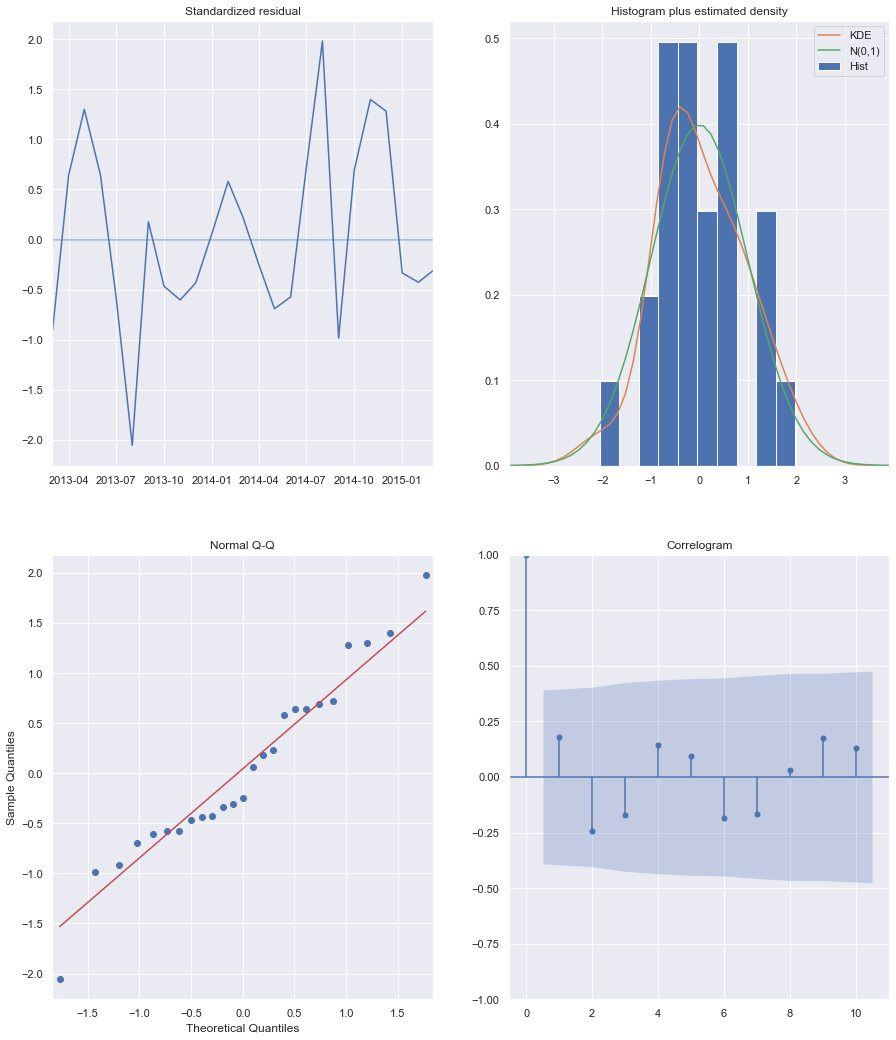

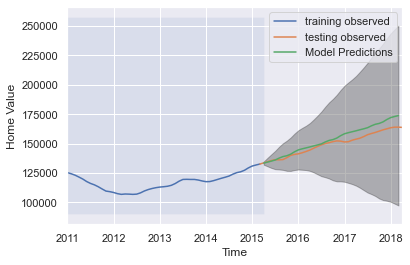

SARIMA Model Result for 60625
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9105      0.077     11.805      0.000       0.759       1.062
ma.L1          0.0227      0.213      0.107      0.915      -0.394       0.440
ar.S.L12      -0.5251      0.110     -4.762      0.000      -0.741      -0.309
ma.S.L12       0.0135      0.017      0.808      0.419      -0.019       0.046
sigma2      1.207e+06   5.77e-08   2.09e+13      0.000    1.21e+06    1.21e+06


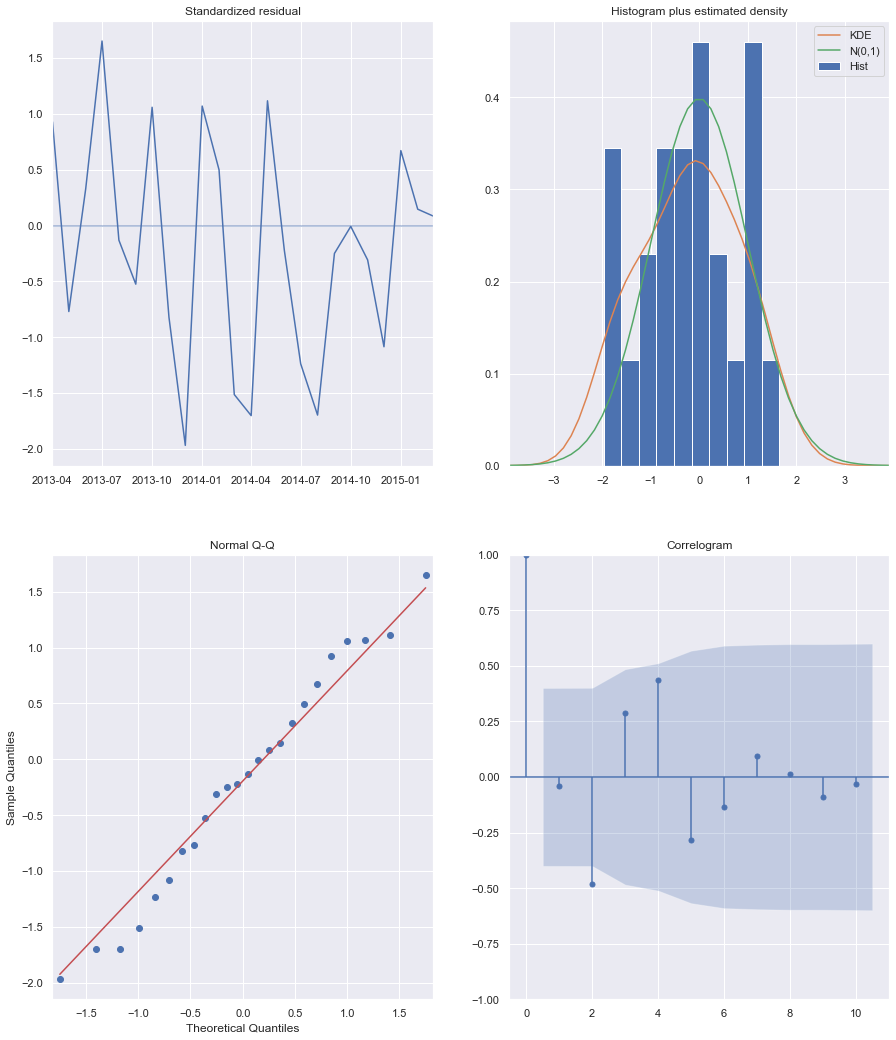

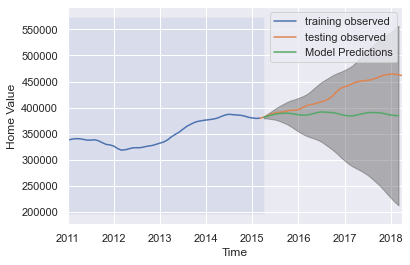

SARIMA Model Result for 60619
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8066      0.228      3.537      0.000       0.360       1.254
ma.L1          0.2733      0.261      1.047      0.295      -0.238       0.785
ar.S.L12      -0.4708      0.474     -0.993      0.321      -1.401       0.459
ma.S.L12      -0.0116      0.036     -0.320      0.749      -0.083       0.059
sigma2      1.841e+06   8.58e+05      2.145      0.032    1.59e+05    3.52e+06


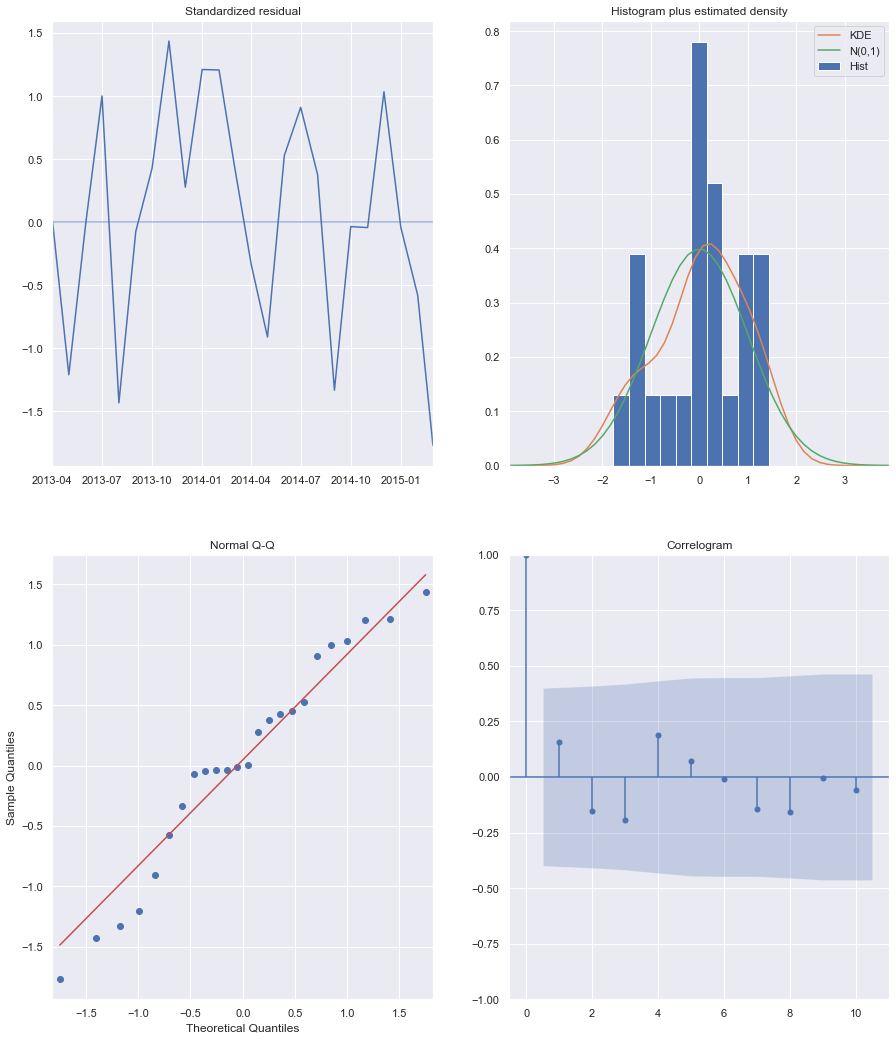

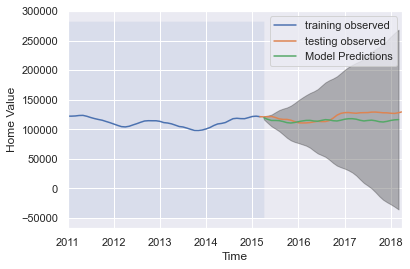

SARIMA Model Result for 60610
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8817      0.118      7.460      0.000       0.650       1.113
ma.L1          0.1054      0.122      0.865      0.387      -0.133       0.344
ar.S.L12      -0.7421      0.175     -4.246      0.000      -1.085      -0.400
ma.S.L12       0.0006      0.028      0.020      0.984      -0.054       0.055
sigma2      2.086e+07   1.51e-09   1.39e+16      0.000    2.09e+07    2.09e+07


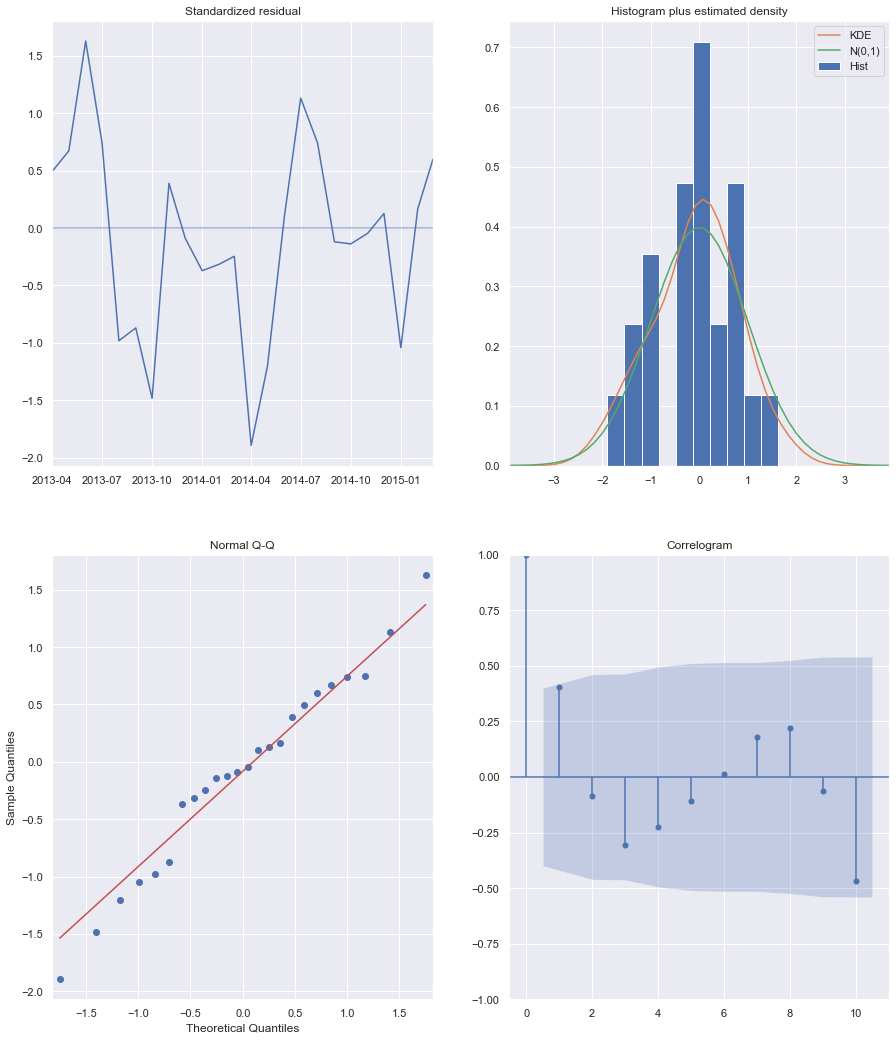

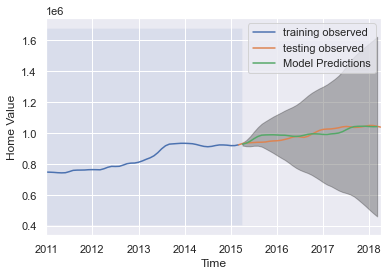

SARIMA Model Result for 60620
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6617      0.298      2.223      0.026       0.078       1.245
ma.L1          0.2357      0.298      0.791      0.429      -0.348       0.820
ar.S.L12      -0.4743      0.401     -1.181      0.237      -1.261       0.313
ma.S.L12      -0.0582      0.070     -0.830      0.406      -0.196       0.079
sigma2      1.664e+06   9.31e+05      1.787      0.074   -1.61e+05    3.49e+06


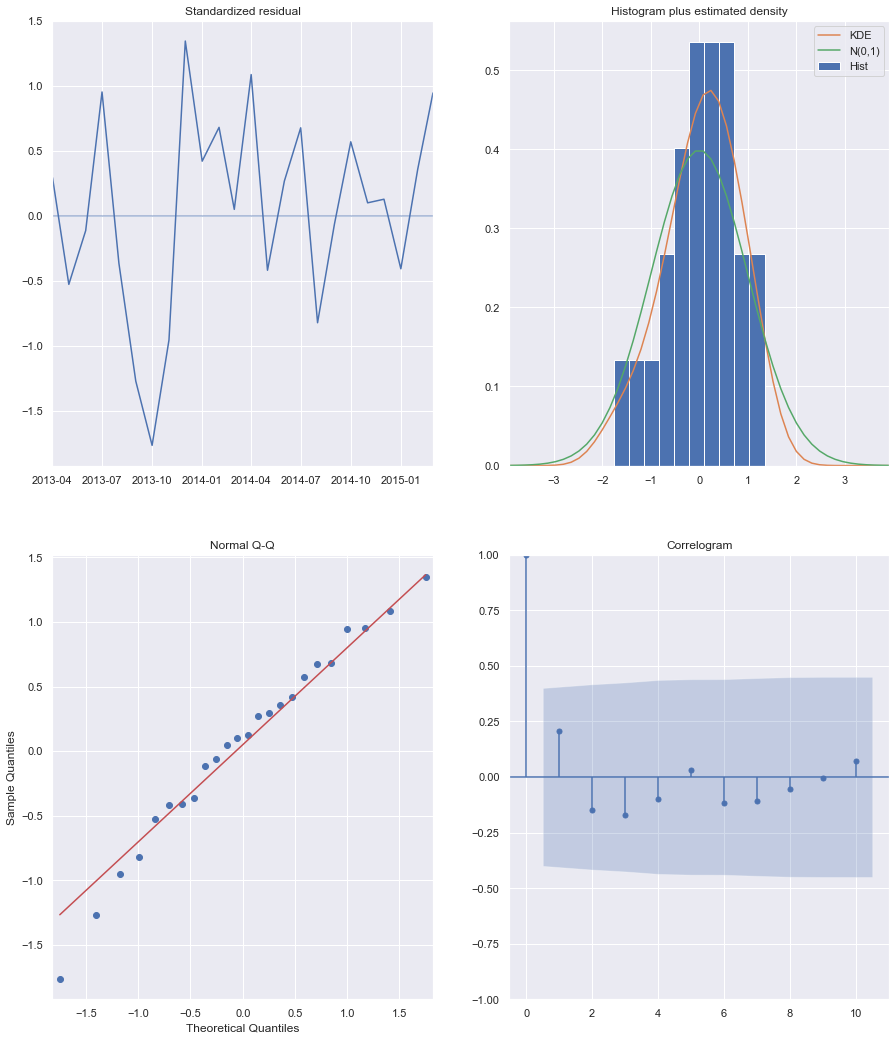

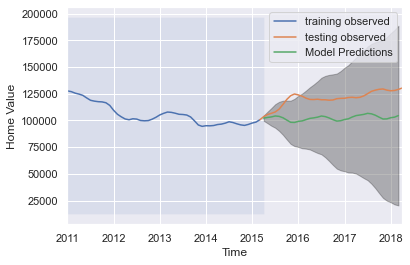

SARIMA Model Result for 60634
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7566      0.184      4.119      0.000       0.397       1.117
ma.L1          0.7496      0.251      2.990      0.003       0.258       1.241
ar.S.L12      -0.0208      0.076     -0.275      0.783      -0.169       0.127
sigma2      8.989e+05   4.42e+05      2.036      0.042    3.35e+04    1.76e+06


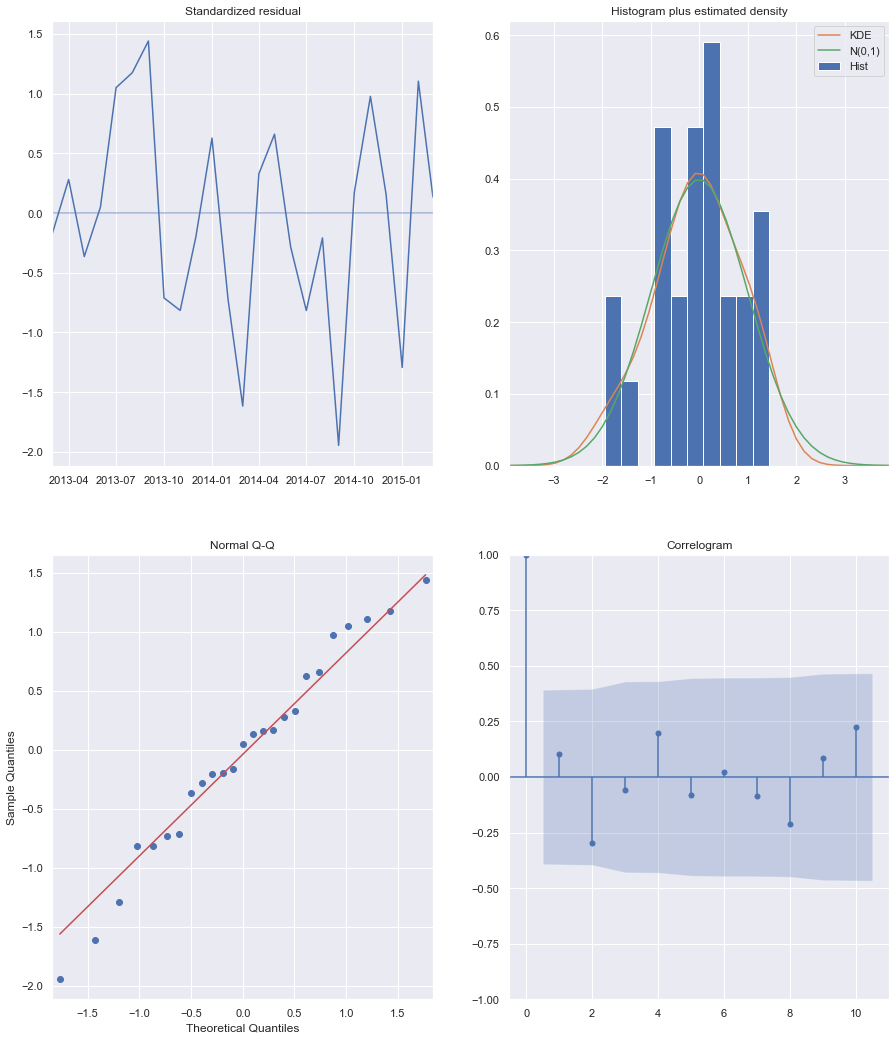

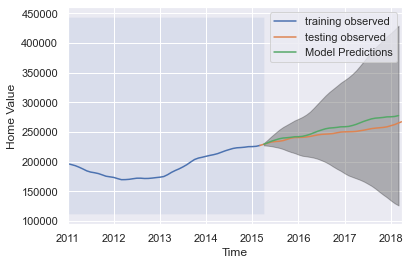

SARIMA Model Result for 60626
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4158      0.332      1.251      0.211      -0.235       1.067
ma.L1          1.2127      0.156      7.794      0.000       0.908       1.518
ar.S.L12       0.0721      0.082      0.874      0.382      -0.089       0.234
sigma2      6.388e+06   1.27e-08   5.04e+14      0.000    6.39e+06    6.39e+06


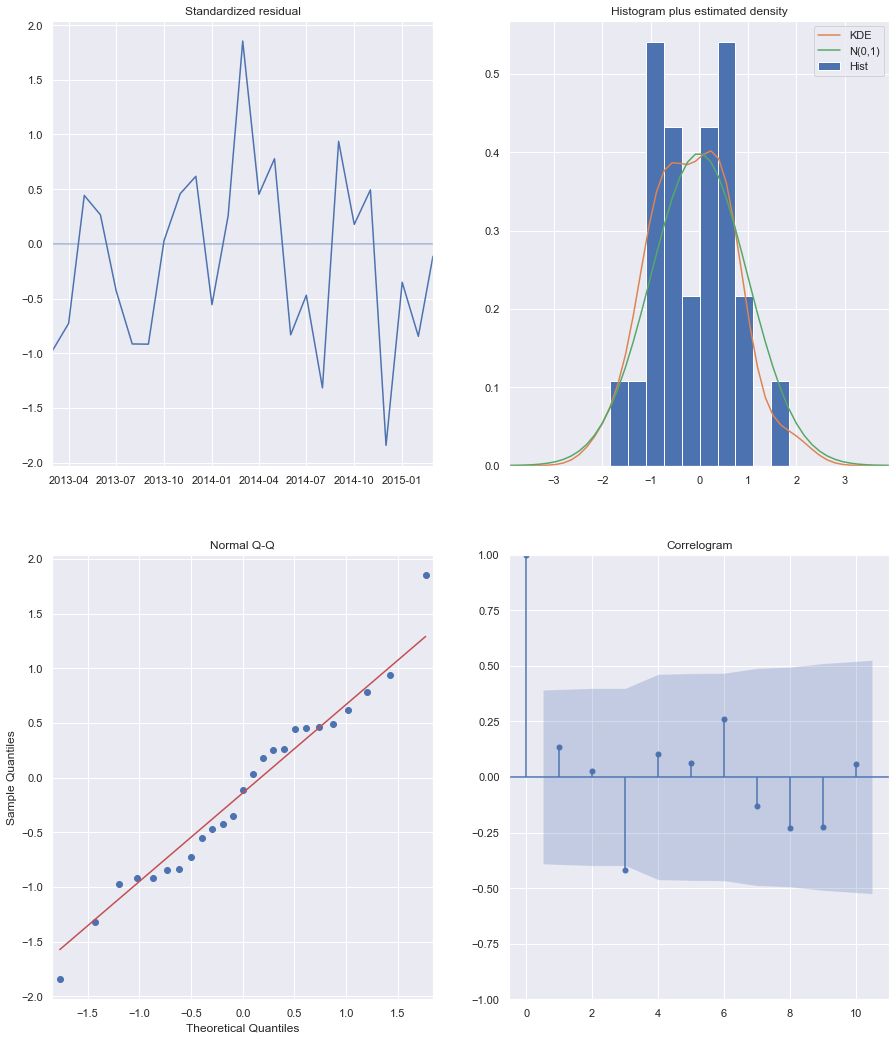

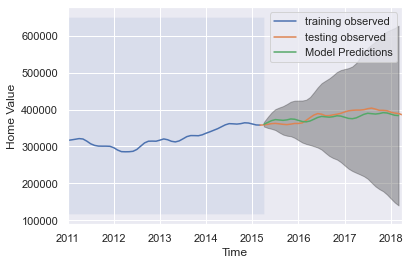

SARIMA Model Result for 60649
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6324      0.276      2.289      0.022       0.091       1.174
ma.L1          0.5669      0.277      2.049      0.041       0.025       1.109
ar.S.L12       0.1370      0.145      0.948      0.343      -0.146       0.420
ma.S.L12      -0.3403      0.298     -1.144      0.253      -0.923       0.243
sigma2      1.427e+06   4.82e+05      2.963      0.003    4.83e+05    2.37e+06


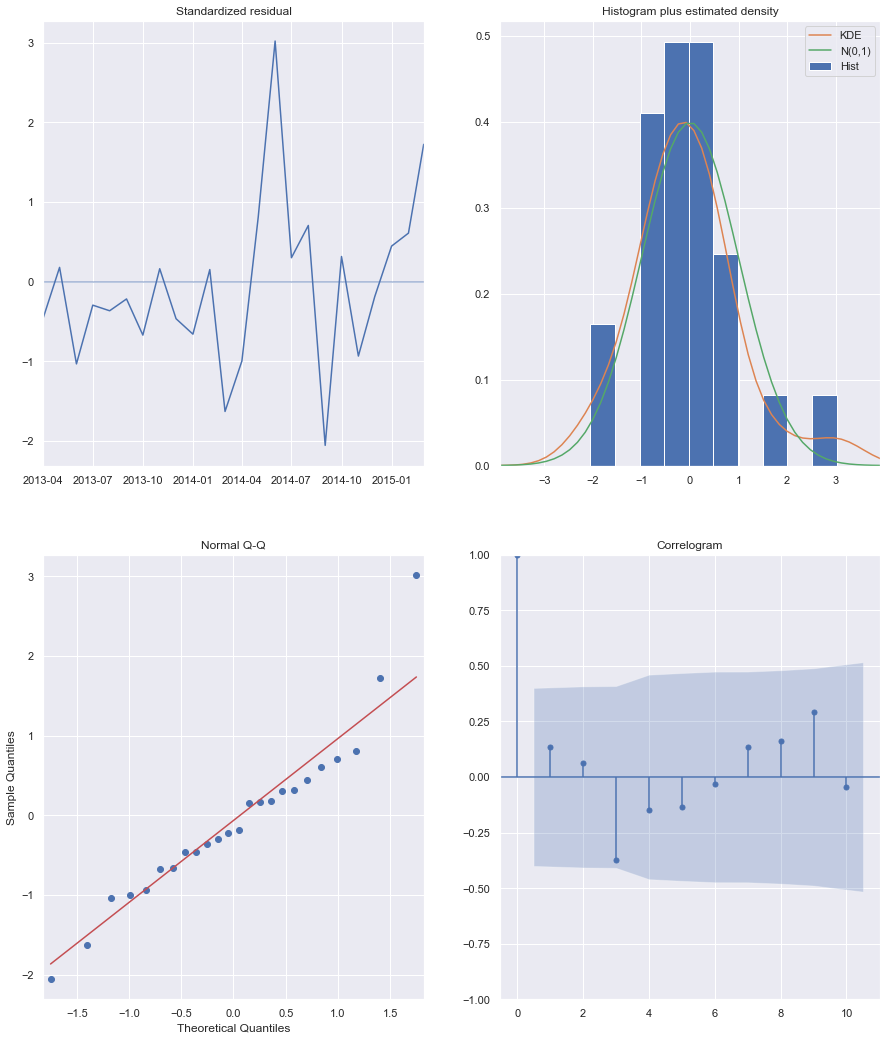

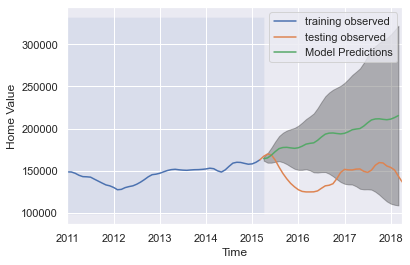

SARIMA Model Result for 60616
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8073      0.300      2.690      0.007       0.219       1.396
ma.L1          0.8817      0.228      3.859      0.000       0.434       1.330
ar.S.L12       0.1173      0.066      1.778      0.075      -0.012       0.247
ma.S.L12      -0.1819      0.140     -1.297      0.195      -0.457       0.093
sigma2      4.112e+06   2.05e-08   2.01e+14      0.000    4.11e+06    4.11e+06


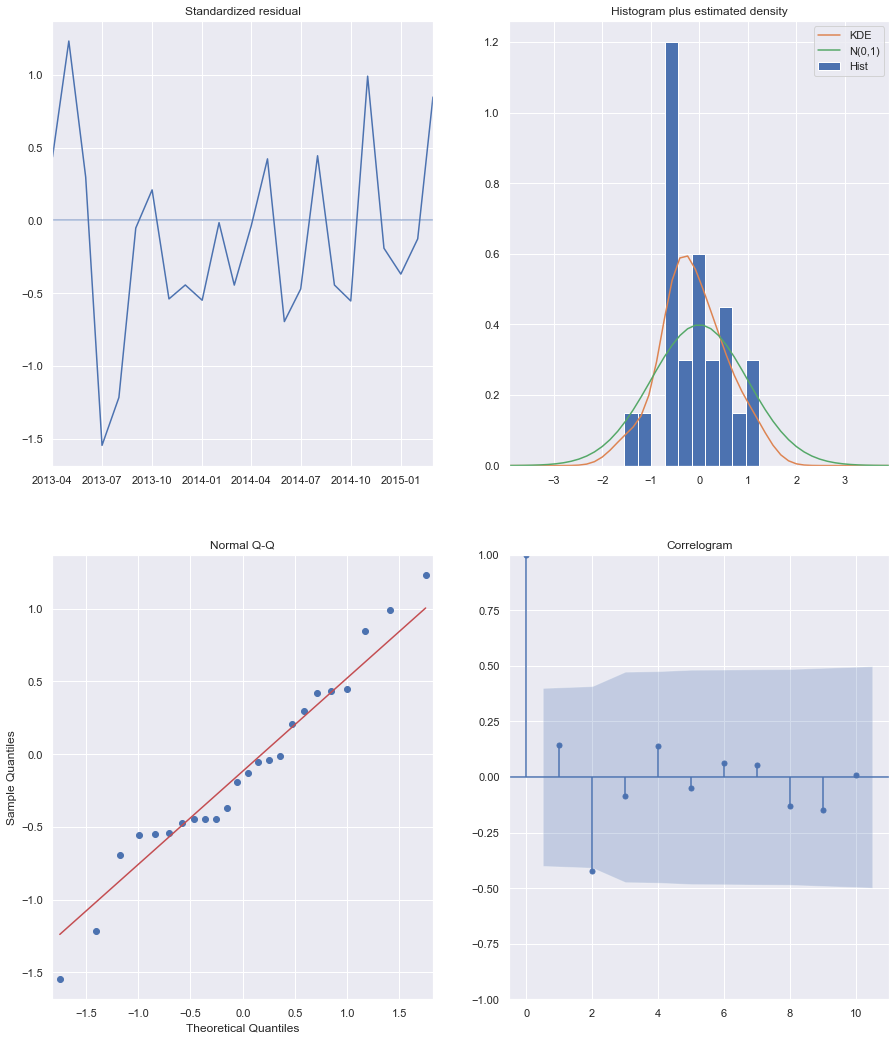

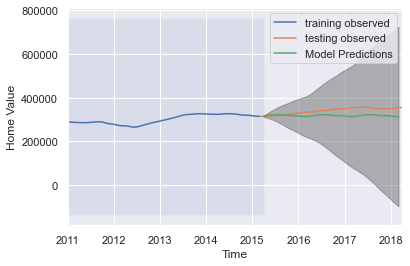

SARIMA Model Result for 60622
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6368      0.149      4.279      0.000       0.345       0.929
ma.L1          0.8475      0.269      3.155      0.002       0.321       1.374
ar.S.L12       0.0751      0.226      0.333      0.739      -0.367       0.517
sigma2      4.117e+06   4.18e-08   9.86e+13      0.000    4.12e+06    4.12e+06


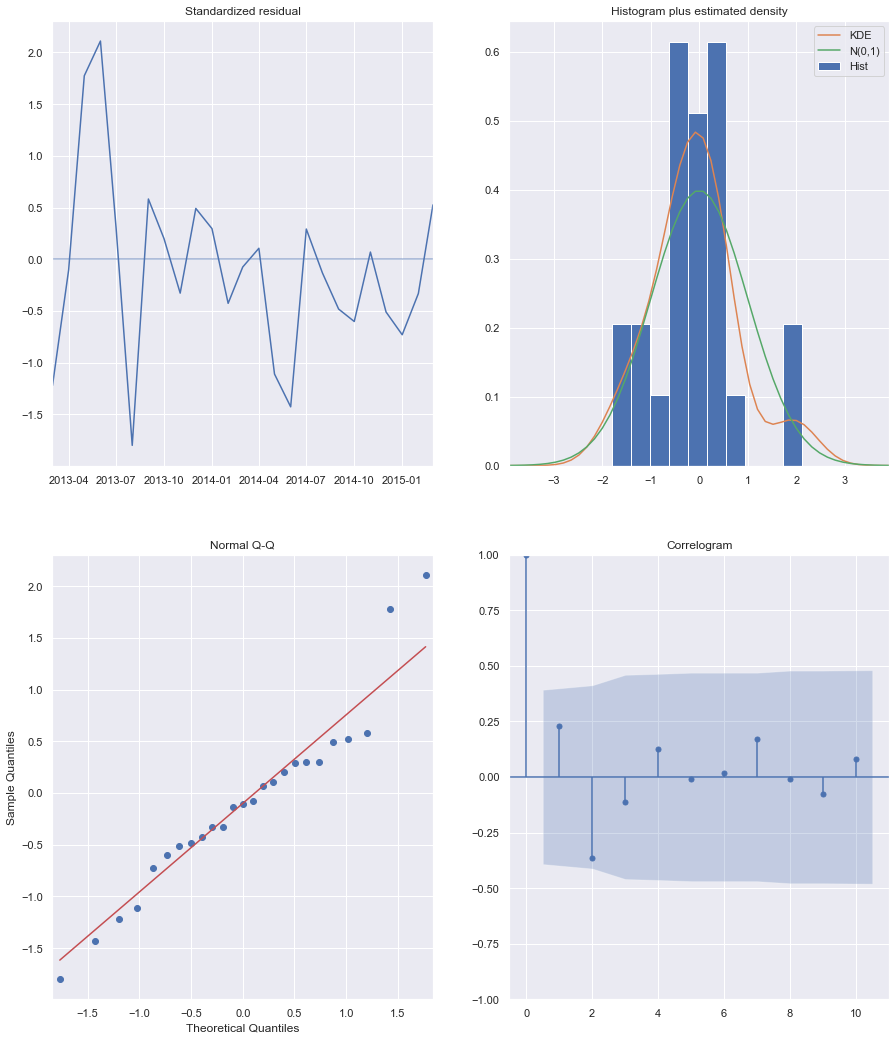

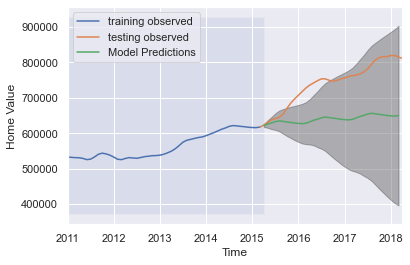

SARIMA Model Result for 60615
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8413      0.152      5.523      0.000       0.543       1.140
ma.L1          0.0237      0.220      0.108      0.914      -0.408       0.455
ar.S.L12      -1.3544      0.353     -3.837      0.000      -2.046      -0.663
ma.S.L12       0.0054      0.027      0.199      0.842      -0.048       0.059
sigma2      4.334e+06   1.01e-08   4.27e+14      0.000    4.33e+06    4.33e+06


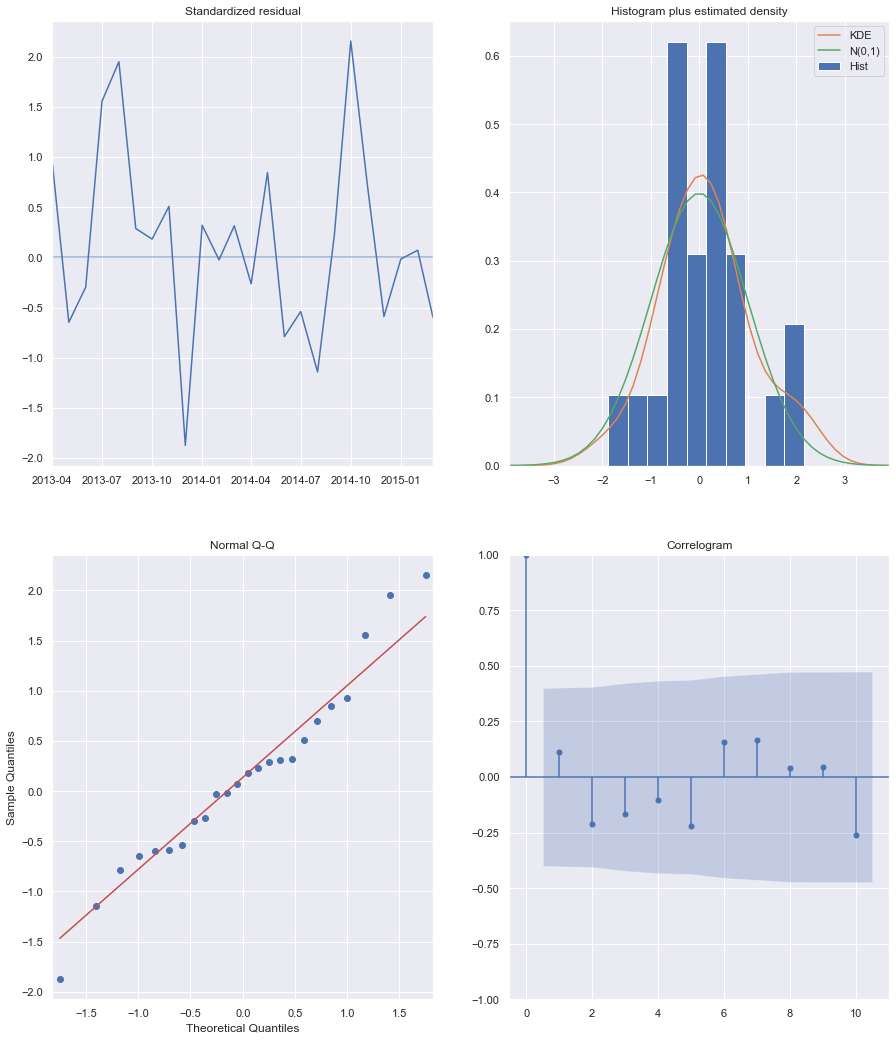

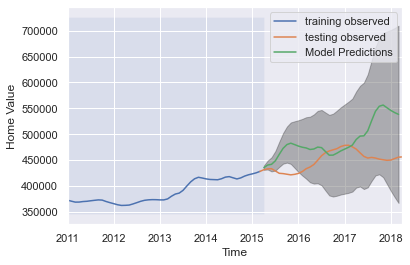

SARIMA Model Result for 60641
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8160      0.195      4.194      0.000       0.435       1.197
ma.L1          0.6488      0.278      2.331      0.020       0.103       1.194
ar.S.L12      -0.0173      0.032     -0.541      0.589      -0.080       0.045
sigma2      1.133e+06   4.39e+05      2.582      0.010    2.73e+05    1.99e+06


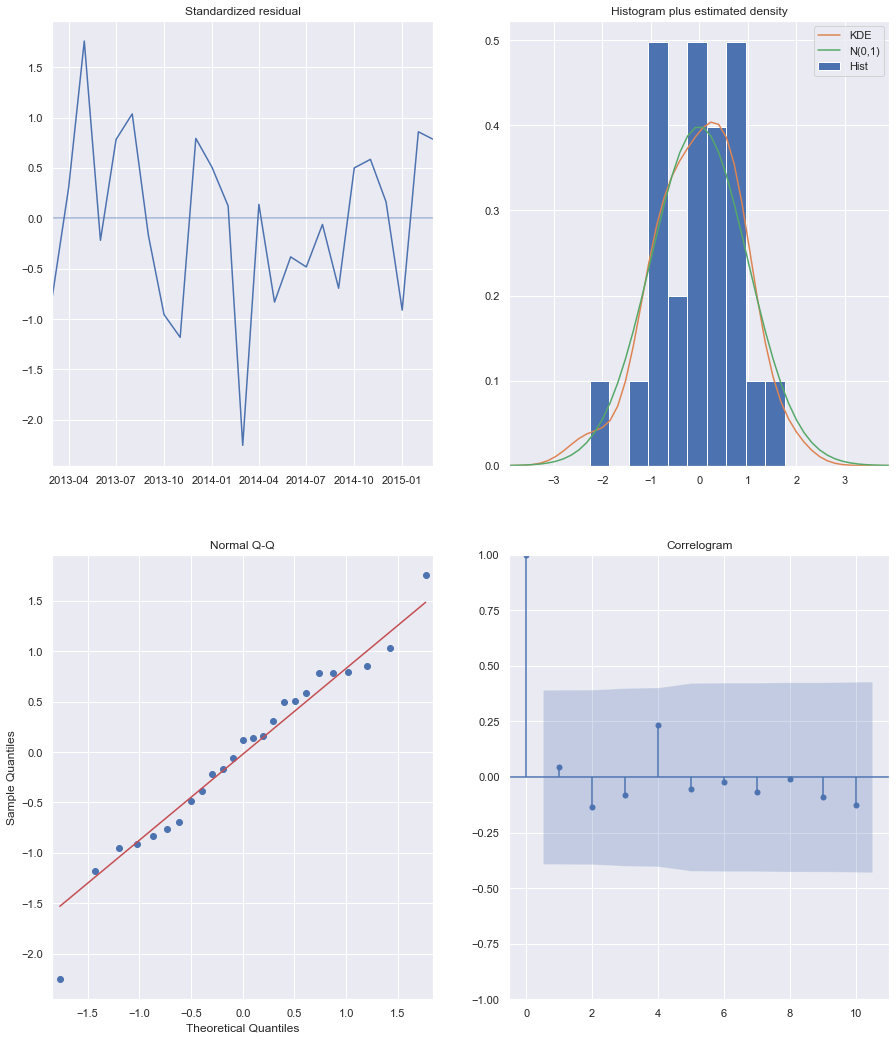

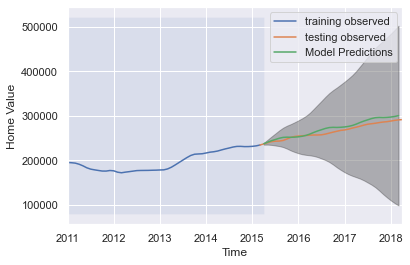

SARIMA Model Result for 60660
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7519      0.134      5.604      0.000       0.489       1.015
ma.L1          0.0431      0.101      0.425      0.671      -0.155       0.242
ar.S.L12      -0.6082      0.202     -3.017      0.003      -1.003      -0.213
sigma2      1.434e+07   2.11e-09   6.79e+15      0.000    1.43e+07    1.43e+07


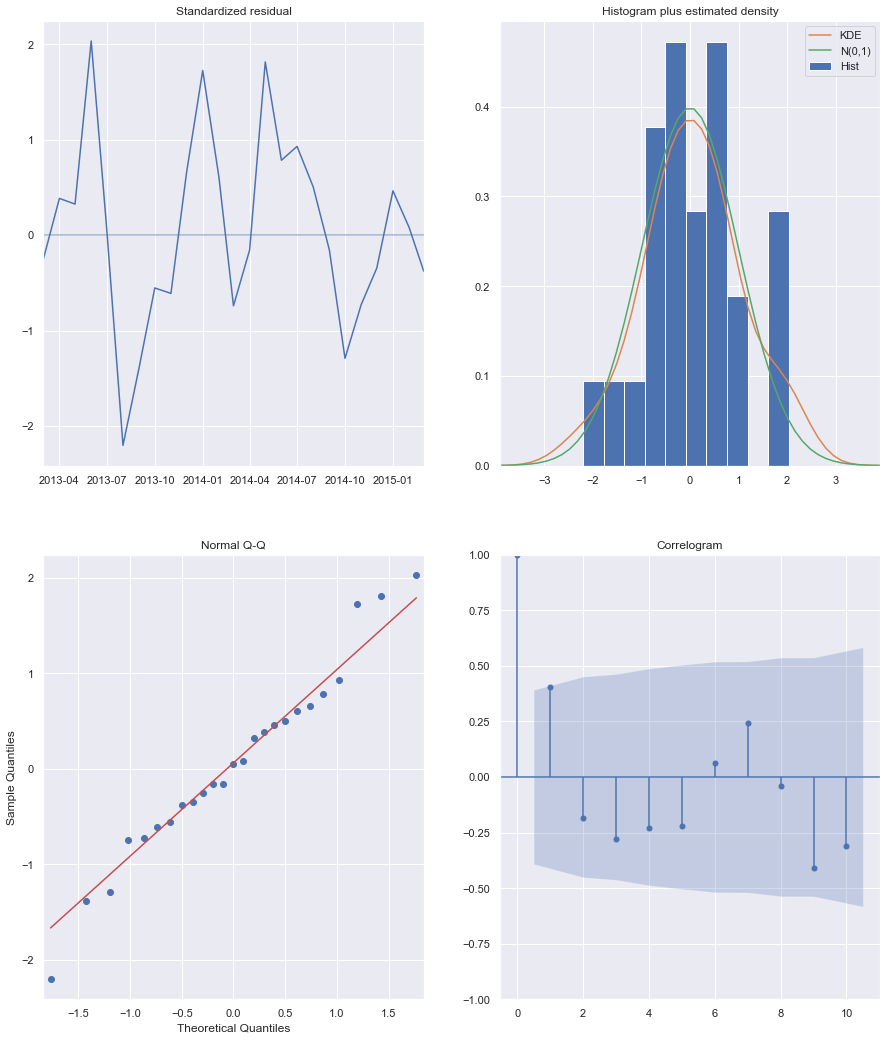

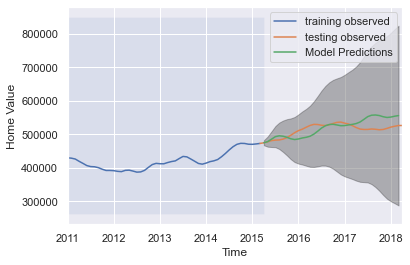

SARIMA Model Result for 60608
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7605      0.194      3.916      0.000       0.380       1.141
ar.S.L12      -0.8080      0.228     -3.540      0.000      -1.255      -0.361
sigma2      2.809e+06   5.27e+05      5.334      0.000    1.78e+06    3.84e+06


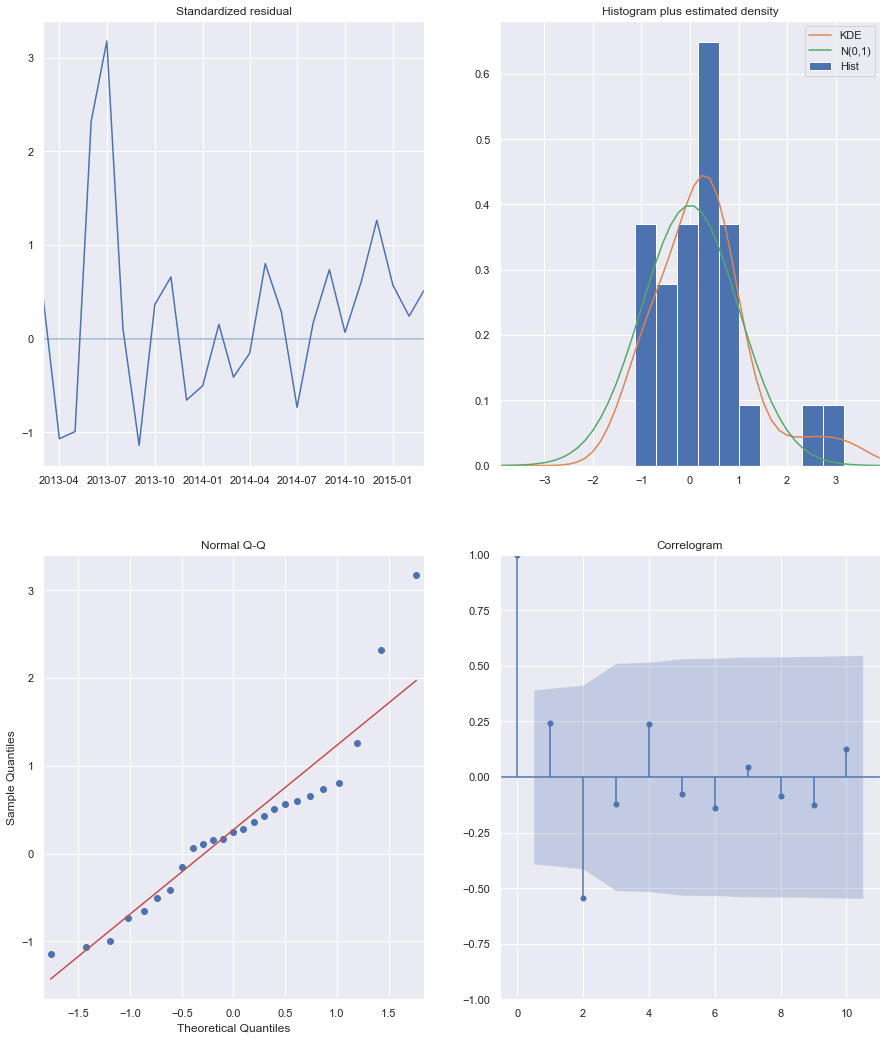

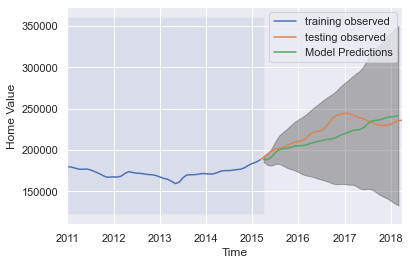

In [127]:
# running best parameters on training set for each zip code into model
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
RMSE_Value = []
confidences = {}
models = {}
for name in zip_list:
    temp_orders = param_dict[name]
    best_para = temp_orders.loc[temp_orders['AIC'].idxmin()]


    ARIMA_MODEL = sm.tsa.SARIMAX(train_dict[name],
                                 order = best_para['pdq'],
                                 seasonal_order = best_para['pdqs'],
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()
    models[name] = output
    output = models[name]        
    
    prediction = output.get_forecast(steps=36, dynamic=False, full_results = True)
    pred_conf = prediction.conf_int()
    confidences[name] = pred_conf
    zip_forecasted = prediction.predicted_mean
    zip_truth = test_dict[name]['2015-04-01':]
    

    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.25)
    

    
    rmse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    mse = ((zip_forecasted - zip_truth)**2).mean()
    
    Zipcode.append(name)
    RMSE_Value.append(rmse)
    MSE_Value.append(mse)
    

    ax = train_dict[name].plot(label='training observed')
    test_dict[name].plot(label='testing observed', ax=ax)


    prediction.predicted_mean.plot(label='Model Predictions', ax=ax)
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.3)

    
    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2011-01-01'), pred.predicted_mean.index[-1], alpha=.1, zorder=-1)

    ax.set_ylabel('Home Value')
#     ax.set_title("Train " + str(name))
#     ax2.set_title("Test " + str(name))
    plt.legend()
    plt.show()
    
summary_table['Zipcode'] = Zipcode
summary_table['MSE'] = MSE_Value
summary_table['RMSE'] = RMSE_Value



In [128]:
summary_table.head()


,Zipcode,MSE,RMSE
0,60657,1.820109e+08,13491.140725
1,60614,1.298797e+08,11396.479192
2,60640,9.090277e+09,95342.941881
3,60647,6.953990e+08,26370.419112
4,60618,1.000696e+09,31633.784668


In [116]:
# confidences

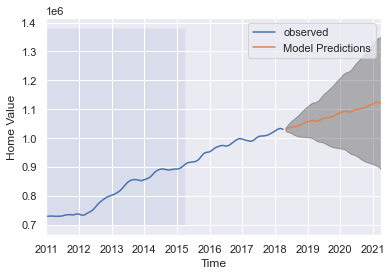

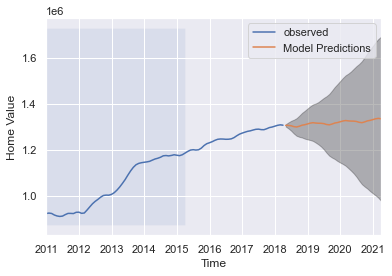

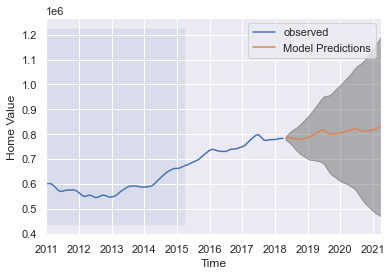

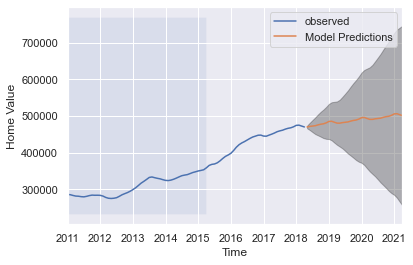

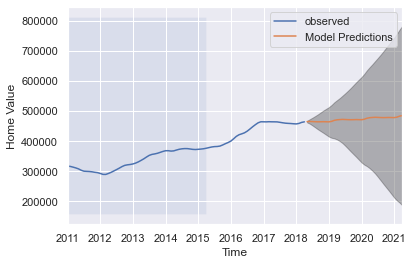

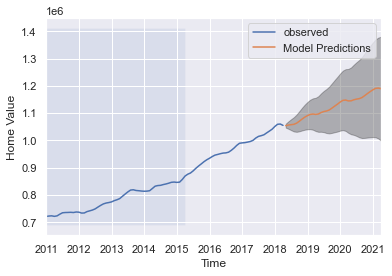

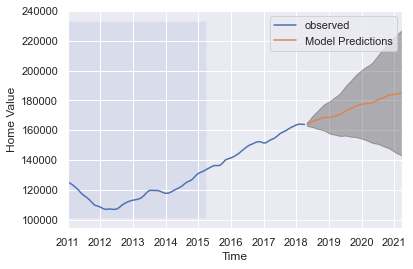

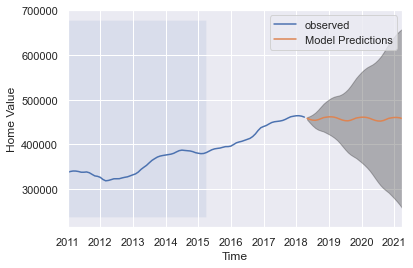

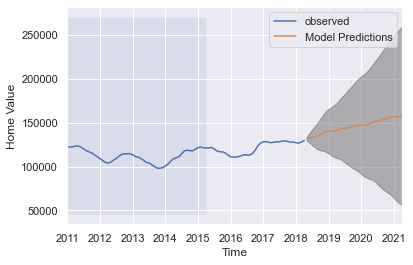

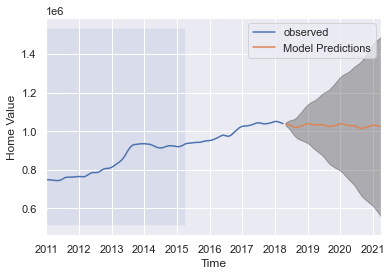

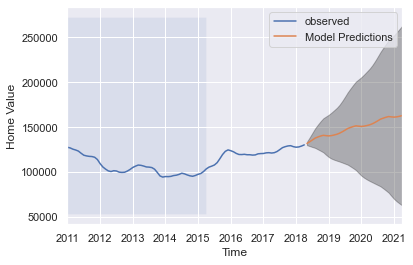

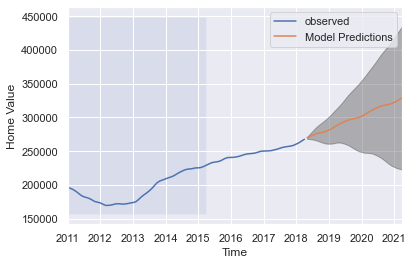

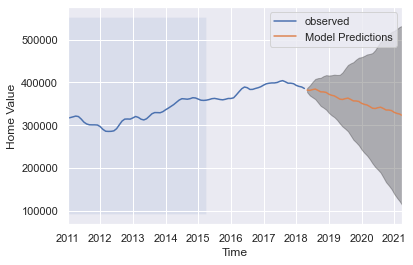

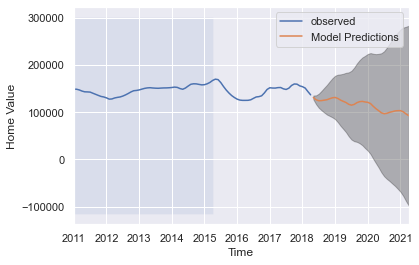

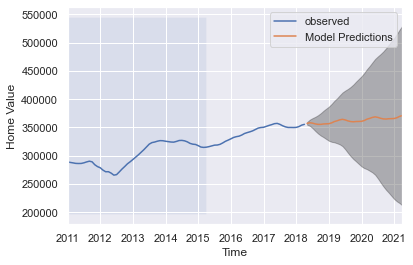

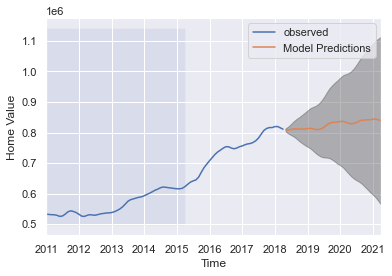

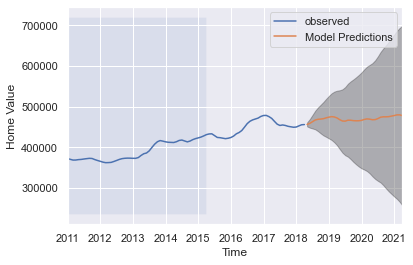

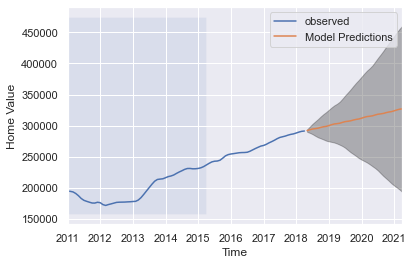

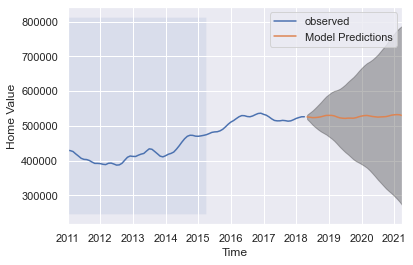

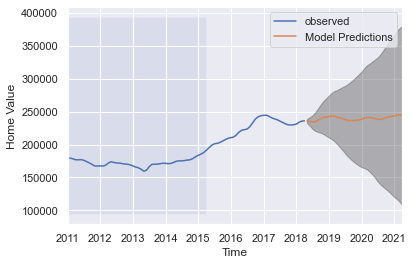

In [179]:
# running best parameters on training set for each zip code into model
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
RMSE_Value = []
confidences = {}
models = {}
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
conf_3Yr_L=[]
conf_3Yr_U=[]
conf_5Yr_L=[]
conf_5Yr_U=[]
for name in zip_list:
    temp_orders = param_dict[name]
    best_para = temp_orders.loc[temp_orders['AIC'].idxmin()]


    ARIMA_MODEL = sm.tsa.SARIMAX(zip_dict[name],
                                 order = best_para['pdq'],
                                 seasonal_order = best_para['pdqs'],
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
    
    output = ARIMA_MODEL.fit()
#     print('SARIMA Model Result for {}'.format(name))
#     print(output.summary().tables[1])
#     output.plot_diagnostics(figsize=(15, 18))
#     plt.show()
    models[name] = output
    output = models[name]        
    
   #get dynamic predictions starting 2015-06-01
#     pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-06-01'), dynamic = True, full_results = True)
#     pred_dynamic_conf = pred_dynamic.conf_int()
#     zip_forecasted = pred_dynamic.predicted_mean
#     zip_truth = zip_dict[name]['2015-06-01':]
#     confidences[name] = pred_dynamic_conf

    rmse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    mse = ((zip_forecasted - zip_truth)**2).mean()
    
    Zipcode.append(name)
    RMSE_Value.append(rmse)
    MSE_Value.append(mse)
    
    prediction = output.get_forecast(steps=36, dynamic=False, full_results = True)
    pred_conf = prediction.conf_int()
    confidences[name] = pred_conf
    zip_forecasted = prediction.predicted_mean
    zip_truth = zip_dict[name]['2015-04-01':]
    
#     ax = train_dict[name].plot(label='training observed')
    ax = zip_dict[name].plot(label='observed')
#     test_dict[name].plot(label='testing observed', ax=ax)


    prediction.predicted_mean.plot(label='Model Predictions', ax=ax)
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=0.3)

    
    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2011-01-01'), pred.predicted_mean.index[-1], alpha=.1, zorder=-1)


#     prediction.predicted_mean.plot(ax=ax, label='Forecast')
#     ax.fill_between(pred_conf.index,
#                     pred_conf.iloc[:, 0],
#                     pred_conf.iloc[:, 1], color='k', alpha=0.25)

#     #Plot the dynamic forecast with confidence intervals as above
#     ax = zip_dict[name].plot(label='observed', figsize=(10, 8))
#     pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

#     ax.fill_between(pred_dynamic_conf.index,
#                     pred_dynamic_conf.iloc[:, 0],
#                     pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    
    
#     ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)
    ax.set_ylabel('Home Value')
#     ax.set_title("Train " + str(name))
#     ax2.set_title("Test " + str(name))
    plt.legend()
    plt.show()
    
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(zip_dict[name]['2018-04'][0])
    
    forecast_3Yr.append(forecast_3)
    conf_3Yr_L.append(pred_conf_3.iloc[:, 0][-1])
    conf_3Yr_U.append(pred_conf_3.iloc[:, 1][-1])
    forecast_5Yr.append(forecast_5)
    conf_5Yr_L.append(pred_conf_5.iloc[:, 0][-1])
    conf_5Yr_U.append(pred_conf_5.iloc[:, 1][-1])

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3 Years Lower'] = conf_3Yr_L
forecast_table['3 Years Upper'] = conf_3Yr_U
forecast_table['5 Years Lower'] = conf_5Yr_L
forecast_table['5 Years Upper'] = conf_5Yr_U

forecast_table['3Yr-ROI']=((forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']*100)
forecast_table['5Yr-ROI']=((forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']*100)
forecast_table['3Yr-ROI-Lower']=(forecast_table['3 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['3Yr-ROI-Upper']=(forecast_table['3 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Lower']=(forecast_table['5 Years Lower'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI-Upper']=(forecast_table['5 Years Upper'] - forecast_table['Current Value'])/forecast_table['Current Value']

    
summary_table['Zipcode'] = Zipcode
summary_table['MSE'] = MSE_Value
summary_table['RMSE'] = RMSE_Value



In [180]:
summary_table.head()

,Zipcode,MSE,RMSE
0,60657,NaN,NaN
1,60614,NaN,NaN
2,60640,NaN,NaN
3,60647,NaN,NaN
4,60618,NaN,NaN


In [181]:
# zip_dict[name]['2018-04'][0]

In [182]:
forecast_table.head()

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
0,60657,1030600.0,1.121286e+06,1.183460e+06,891769.364222,1.350802e+06,734361.459457,1.632558e+06,8.799294,14.832098,-0.134709,0.310694,-0.287443,0.584085
1,60614,1307000.0,1.335070e+06,1.353837e+06,978655.889326,1.691484e+06,623397.431300,2.084276e+06,2.147647,3.583525,-0.251220,0.294173,-0.523032,0.594702
2,60640,782800.0,8.305055e+05,8.591618e+05,469460.982951,1.191550e+06,153991.388382,1.564332e+06,6.094208,9.754954,-0.400280,0.522164,-0.803281,0.998380
3,60647,470200.0,5.011533e+05,5.216897e+05,256637.919710,7.456687e+05,22278.805590,1.021101e+06,6.583011,10.950596,-0.454194,0.585854,-0.952618,1.171630
4,60618,464300.0,4.850710e+05,4.991065e+05,186822.297519,7.833198e+05,-125643.126607,1.123856e+06,4.473625,7.496551,-0.597626,0.687098,-1.270608,1.420539


In [183]:
confidences[60647].head()


,lower 60647,upper 60647
2018-05-01,466501.104314,473828.149937
2018-06-01,461658.198778,481752.354166
2018-07-01,456117.343784,489150.260699
2018-08-01,450811.535133,496228.699688
2018-09-01,447324.406533,504319.957828


In [184]:
zip_dict[60647]

Time
2011-01-01    286500.0
2011-02-01    285800.0
2011-03-01    283800.0
2011-04-01    282100.0
2011-05-01    281700.0
                ...   
2017-12-01    470600.0
2018-01-01    474500.0
2018-02-01    475100.0
2018-03-01    472600.0
2018-04-01    470200.0
Name: 60647, Length: 88, dtype: float64

In [186]:
Yr3_forecast_table.sort_values('3Yr-ROI', ascending=False).head()

,Zipcode,Current Value,3 Years Value,3Yr-ROI
13,60649,136800.0,215483.108835,57.516892
2,60640,782800.0,951809.318112,21.590357
16,60615,456200.0,538407.260523,18.020004
6,60629,163800.0,173850.491454,6.135831
18,60660,526300.0,555939.462589,5.631667


In [187]:
forecast_table.sort_values('5Yr-ROI', ascending = False).head()

,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
10,60620,130300.0,1.629457e+05,1.835909e+05,62810.971920,2.630805e+05,-5127.986180,3.723098e+05,25.054284,40.898611,-0.517951,1.019037,-1.039355,1.857327
11,60634,267600.0,3.293056e+05,3.704039e+05,222746.642362,4.358646e+05,152334.593188,5.884733e+05,23.058910,38.417017,-0.167613,0.628792,-0.430738,1.199078
8,60619,129600.0,1.580718e+05,1.755305e+05,55601.900029,2.605417e+05,-22333.316904,3.733943e+05,21.968977,35.440211,-0.570973,1.010353,-1.172325,1.881129
6,60629,163800.0,1.849908e+05,1.999104e+05,142604.074091,2.273775e+05,118065.035615,2.817557e+05,12.936985,22.045413,-0.129401,0.388141,-0.279212,0.720121
5,60613,1055300.0,1.189647e+06,1.282721e+06,999545.031288,1.379749e+06,918382.033695,1.647059e+06,12.730678,21.550334,-0.052833,0.307447,-0.129743,0.560750


In [193]:
forecast_plot = forecast_table.loc[(forecast_table['Zipcode']==60620) | 
                                  (forecast_table['Zipcode']==60634) |
                          (forecast_table['Zipcode']==60619) |
                          (forecast_table['Zipcode']==60629) |
                          (forecast_table['Zipcode']==60613)] 
                        
# forecast_plot
forecast_plot.head()


,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
5,60613,1055300.0,1.189647e+06,1.282721e+06,999545.031288,1.379749e+06,918382.033695,1.647059e+06,12.730678,21.550334,-0.052833,0.307447,-0.129743,0.560750
6,60629,163800.0,1.849908e+05,1.999104e+05,142604.074091,2.273775e+05,118065.035615,2.817557e+05,12.936985,22.045413,-0.129401,0.388141,-0.279212,0.720121
8,60619,129600.0,1.580718e+05,1.755305e+05,55601.900029,2.605417e+05,-22333.316904,3.733943e+05,21.968977,35.440211,-0.570973,1.010353,-1.172325,1.881129
10,60620,130300.0,1.629457e+05,1.835909e+05,62810.971920,2.630805e+05,-5127.986180,3.723098e+05,25.054284,40.898611,-0.517951,1.019037,-1.039355,1.857327
11,60634,267600.0,3.293056e+05,3.704039e+05,222746.642362,4.358646e+05,152334.593188,5.884733e+05,23.058910,38.417017,-0.167613,0.628792,-0.430738,1.199078


In [196]:
plot_3ROI = pd.DataFrame()

plot_3ROI['Zipcode'] = forecast_plot['Zipcode']
plot_3ROI['Current Value'] = forecast_plot['Current Value']
plot_3ROI['3 Years Value'] = forecast_plot['3 Years Value']
plot_3ROI['5 Years Value'] = forecast_plot['5 Years Value']
plot_3ROI.set_index('Zipcode', inplace=True)
plot_3ROI.head()

,Current Value,3 Years Value,5 Years Value
Zipcode,,,
60613,1055300.0,1.189647e+06,1.282721e+06
60629,163800.0,1.849908e+05,1.999104e+05
60619,129600.0,1.580718e+05,1.755305e+05
60620,130300.0,1.629457e+05,1.835909e+05
60634,267600.0,3.293056e+05,3.704039e+05


In [203]:
plot_3conf = pd.DataFrame()
plot_3conf['Zipcode'] = forecast_plot['Zipcode']
plot_3conf['Current Value'] = forecast_plot['Current Value']
plot_3conf['3 Years Lower'] = forecast_plot['3 Years Lower']
plot_3conf['3 Years Upper'] = forecast_plot['3 Years Upper']
plot_3conf.set_index('Zipcode', inplace=True)
plot_3conf.head()

,Current Value,3 Years Lower,3 Years Upper
Zipcode,,,
60613,1055300.0,999545.031288,1.379749e+06
60629,163800.0,142604.074091,2.273775e+05
60619,129600.0,55601.900029,2.605417e+05
60620,130300.0,62810.971920,2.630805e+05
60634,267600.0,222746.642362,4.358646e+05


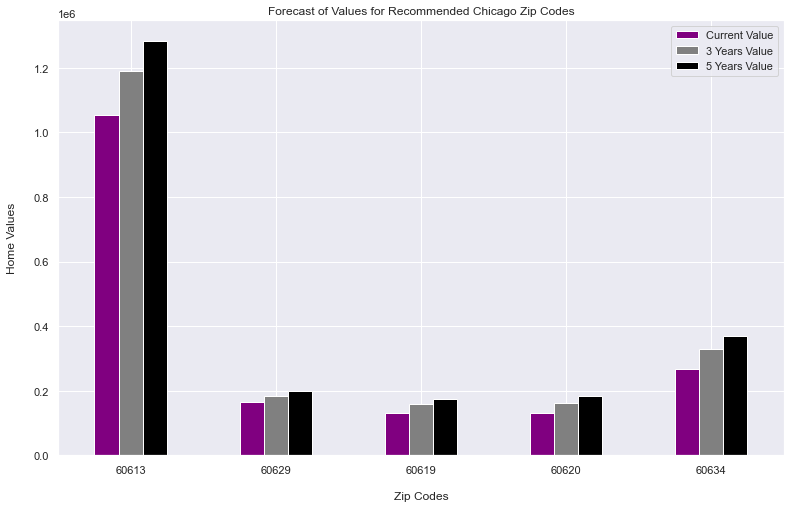

In [204]:
plot_3ROI.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'], rot=0)                                       
plt.title("", y=1.013, fontsize=22)
plt.xlabel("Zip Codes", labelpad=16)
plt.ylabel("Home Values", labelpad=16)
plt.title('Forecast of Values for Recommended Chicago Zip Codes')
plt.show()

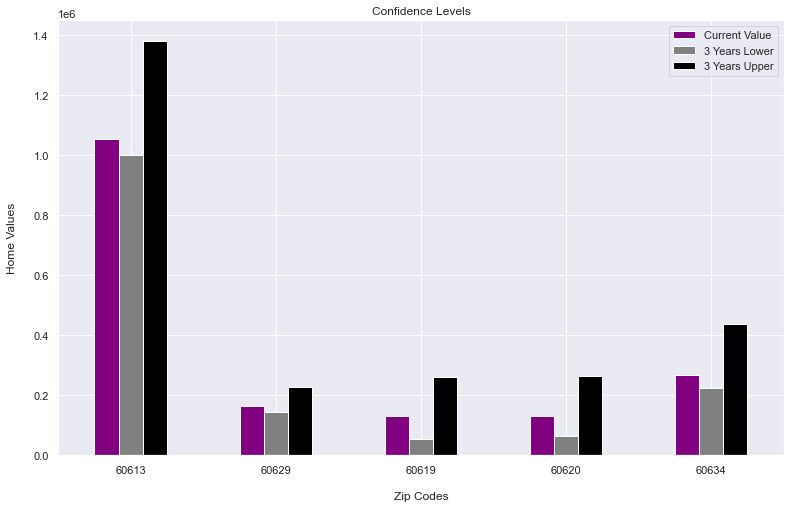

In [206]:
plot_3conf.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'], rot=0)                                       
plt.title("", y=1.013, fontsize=22)
plt.xlabel("Zip Codes", labelpad=16)
plt.ylabel("Home Values", labelpad=16)
plt.title('Confidence Levels')
plt.show()

In [213]:
plot_5conf = pd.DataFrame()
plot_5conf['Zipcode'] = forecast_plot['Zipcode']
plot_5conf['Current Value'] = forecast_plot['Current Value']
plot_5conf['5 Years Lower'] = forecast_plot['5 Years Lower']
plot_5conf['5 Years Upper'] = forecast_plot['5 Years Upper']
plot_5conf.set_index('Zipcode', inplace=True)
plot_5conf.head()

,Current Value,5 Years Lower,5 Years Upper
Zipcode,,,
60613,1055300.0,918382.033695,1.647059e+06
60629,163800.0,118065.035615,2.817557e+05
60619,129600.0,-22333.316904,3.733943e+05
60620,130300.0,-5127.986180,3.723098e+05
60634,267600.0,152334.593188,5.884733e+05


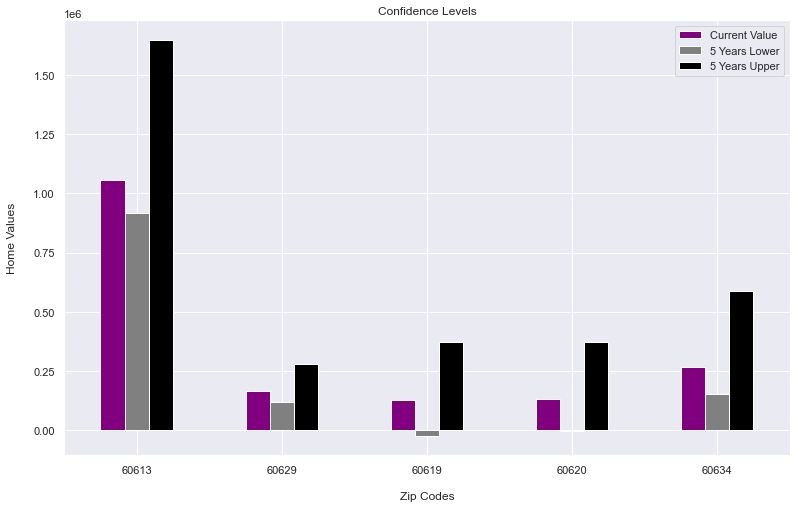

In [214]:
plot_5conf.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'], rot=0)                                       
plt.title("", y=1.013, fontsize=22)
plt.xlabel("Zip Codes", labelpad=16)
plt.ylabel("Home Values", labelpad=16)
plt.title('Confidence Levels')
plt.show()

In [209]:
forecast_3plot = forecast_table.loc[(forecast_table['Zipcode']==60649) | 
                                  (forecast_table['Zipcode']==60640) |
                          (forecast_table['Zipcode']==60615) |
                          (forecast_table['Zipcode']==60629) |
                          (forecast_table['Zipcode']==60660)] 
                        
# forecast_plot
forecast_3plot.head()


,Zipcode,Current Value,3 Years Value,5 Years Value,3 Years Lower,3 Years Upper,5 Years Lower,5 Years Upper,3Yr-ROI,5Yr-ROI,3Yr-ROI-Lower,3Yr-ROI-Upper,5Yr-ROI-Lower,5Yr-ROI-Upper
2,60640,782800.0,830505.459903,859161.782062,469460.982951,1.191550e+06,153991.388382,1.564332e+06,6.094208,9.754954,-0.400280,0.522164,-0.803281,0.998380
6,60629,163800.0,184990.780837,199910.386854,142604.074091,2.273775e+05,118065.035615,2.817557e+05,12.936985,22.045413,-0.129401,0.388141,-0.279212,0.720121
13,60649,136800.0,92888.044050,62954.842045,-97361.543662,2.831376e+05,-306343.958213,4.322536e+05,-32.099383,-53.980379,-1.711707,1.069720,-3.239356,2.159749
16,60615,456200.0,478292.870263,485937.005746,257176.476105,6.994093e+05,54932.312545,9.169417e+05,4.842804,6.518414,-0.436264,0.533120,-0.879587,1.009955
18,60660,526300.0,529696.754895,533257.692447,271092.093458,7.883014e+05,28655.809209,1.037860e+06,0.645403,1.322001,-0.484910,0.497818,-0.945552,0.971992


In [210]:
plot_top = pd.DataFrame()

plot_top['Zipcode'] = forecast_3plot['Zipcode']
plot_top['Current Value'] = forecast_3plot['Current Value']
plot_top['3 Years Value'] = forecast_3plot['3 Years Value']
plot_top['5 Years Value'] = forecast_3plot['5 Years Value']
plot_top.set_index('Zipcode', inplace=True)
plot_top.head()

,Current Value,3 Years Value,5 Years Value
Zipcode,,,
60640,782800.0,830505.459903,859161.782062
60629,163800.0,184990.780837,199910.386854
60649,136800.0,92888.044050,62954.842045
60615,456200.0,478292.870263,485937.005746
60660,526300.0,529696.754895,533257.692447


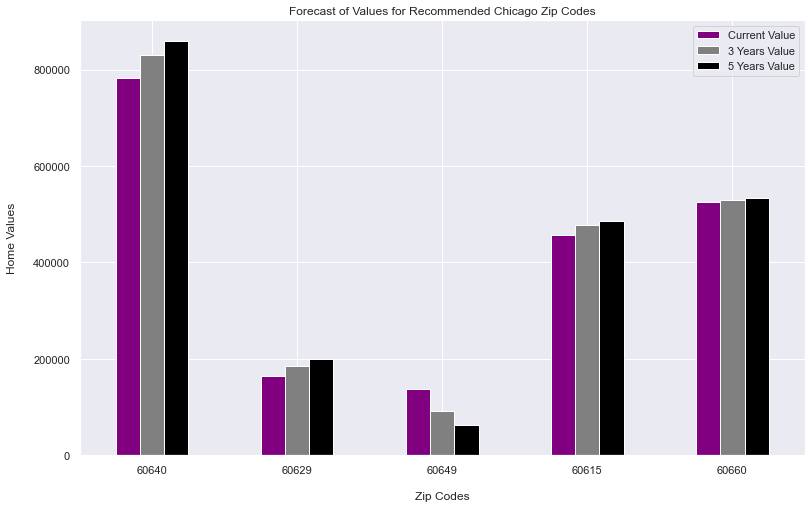

In [215]:
plot_top.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'], rot=0)                                       
plt.title("", y=1.013, fontsize=22)
plt.xlabel("Zip Codes", labelpad=16)
plt.ylabel("Home Values", labelpad=16)
plt.title('Forecast of Values for Recommended Chicago Zip Codes')
plt.show()

In [216]:
plot_3top = pd.DataFrame()

plot_3top['Zipcode'] = forecast_3plot['Zipcode']
plot_3top['Current Value'] = forecast_3plot['Current Value']
plot_3top['3 Years Lower'] = forecast_3plot['3 Years Value']
plot_3top['3 Years Upper'] = forecast_3plot['5 Years Upper']
plot_3top.set_index('Zipcode', inplace=True)
plot_3top.head()


,Current Value,3 Years Lower,3 Years Upper
Zipcode,,,
60640,782800.0,830505.459903,1.564332e+06
60629,163800.0,184990.780837,2.817557e+05
60649,136800.0,92888.044050,4.322536e+05
60615,456200.0,478292.870263,9.169417e+05
60660,526300.0,529696.754895,1.037860e+06


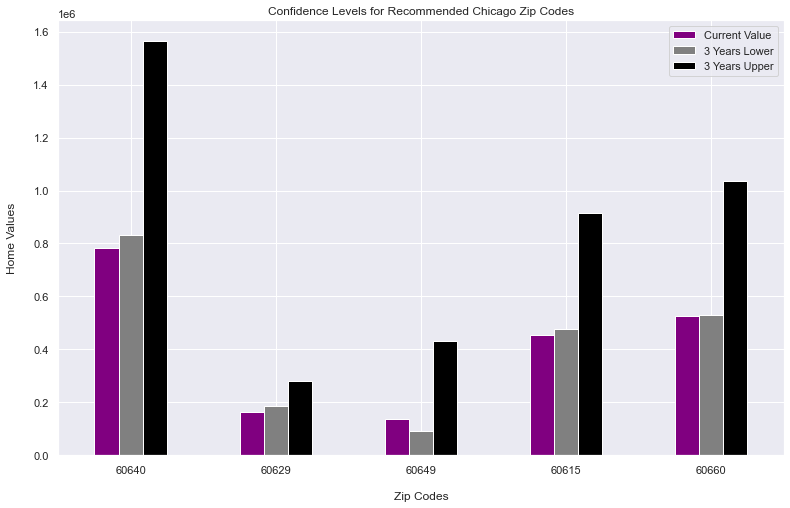

In [218]:
plot_3top.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'], rot=0)                                       
plt.title("", y=1.013, fontsize=22)
plt.xlabel("Zip Codes", labelpad=16)
plt.ylabel("Home Values", labelpad=16)
plt.title('Confidence Levels for Recommended Chicago Zip Codes')
plt.show()

In [219]:
plot_roi = pd.DataFrame()

plot_roi['Zipcode'] = forecast_3plot['Zipcode']
plot_roi['3Yr-ROI'] = forecast_3plot['3Yr-ROI']
plot_roi['5Yr-ROI'] = forecast_3plot['5Yr-ROI']

plot_roi.set_index('Zipcode', inplace=True)
plot_roi.head()


,3Yr-ROI,5Yr-ROI
Zipcode,,
60640,6.094208,9.754954
60629,12.936985,22.045413
60649,-32.099383,-53.980379
60615,4.842804,6.518414
60660,0.645403,1.322001


In [222]:
# plot_roi.plot(kind='bar', figsize=(13, 8), color=['purple', 'gray', 'black'], rot=0)                                       
# plt.title("", y=1.013, fontsize=22)
# plt.xlabel("Zip Codes", labelpad=16)
# plt.ylabel("Home Values", labelpad=16)
# plt.title('Confidence Levels for Recommended Chicago Zip Codes')
# plt.show()